# Tully-Fisher Relation of galaxies

For all galaxies in Jura (Y3) which have valid rotational velocities at $0.4R_{26}$, plot their TFR.  Also include the best-fit TFR (as calibrated using `TF_Y3_zbin_calibration_weightsVmax-1_HDBSCAN_colors.ipynb` with redshift bins of width 0.005 and outliers defined with HDBSCAN), but with no 0pt calibration.

In [1]:
from astropy.table import Table, join
from astropy.cosmology import Planck18, LambdaCDM, FlatLambdaCDM
from astropy.coordinates import Distance
from astropy.io import fits
import astropy.units as u
import astropy.constants as const
from scipy.stats import gaussian_kde
from tqdm import tqdm

import numpy as np

from scipy.stats import binned_statistic

from hdbscan import HDBSCAN

import pickle

import os

import matplotlib.pyplot as plt

# Custom functions / classes
import sys
# sys.path.insert(1, '/global/u1/k/kadglass/DESI_SGA/TF/')
# sys.path.insert(1, '/Users/kdouglass/Documents/Research/DESI/PV_survey/code/TF/')
sys.path.insert(1, '/global/u1/s/sgmoore1/DESI_SGA/TF/')
from TF_photoCorrect import BASS_corr, MW_dust, k_corr, internal_dust
from z_CMB_convert import convert_z_frame

In [2]:
h = 1
H0 = 100*h

c = const.c.to('km/s')

q0 = 0.2

# Data

In [3]:
# SGA_TF = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot_VI.fits')
# SGA_TF = Table.read('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y1/SGA-2020_iron_Vrot_dVsys_VI_photsys.fits')

SGA_TF = Table.read('../vrot_cats/SGA-2020_jura_Vrot_v0.fits')
SGA_TF[:5]

<Table length=5>
SGA_ID  SGA_GALAXY ...      V_0p4R26         V_0p4R26_ERR   
int64    bytes16   ...      float64            float64      
------ ----------- ... ------------------ ------------------
    20 SGA-2020 20 ... 136.41609817193677 13.124519097706607
    32 SGA-2020 32 ... 241.38910738701114 16.455981009957803
    38 SGA-2020 38 ... 121.85181571803045  11.00570442529723
    53 SGA-2020 53 ... 245.09271422144894  13.42596520278498
    55 SGA-2020 55 ...  82.26919023451443 6.5545942979132175

## Morphologies

Do our results improve if we only consider spiral and irregular galaxies?

In [4]:
ai_morphpath = '../'
# ai_morphpath = '/global/cfs/cdirs/desi/science/td/pv/SGA2020'
ai_morphcsv = os.path.join(ai_morphpath, 'SGAY3TFMorphologies.csv')

ai_morphtab = Table.read(ai_morphcsv)
ai_morphtab[:5]

<Table length=5>
 SGA_ID  Predicted_Type_spiral ... Predicted_Type_lenticular Predicted_Type
float64           str6         ...           str10               str10     
-------- --------------------- ... ------------------------- --------------
218203.0                 Other ...                     Other      Irregular
218205.0                 Other ...                     Other      Irregular
218239.0                 Other ...                     Other      Irregular
218275.0                 Other ...                     Other      Irregular
218304.0                Spiral ...                     Other         Spiral

### Combine ML morphtypes with SGA catalog

In [5]:
SGA_TF = join(SGA_TF, ai_morphtab['SGA_ID', 'Predicted_Type'], keys='SGA_ID', join_type='left')

# Rename Predicted_Type to MORPHTYPE_AI
SGA_TF['Predicted_Type'].name = 'MORPHTYPE_AI'

In [6]:
SGA_TF['SGA_ID', 'MORPHTYPE_AI'][:5]

<Table length=5>
 SGA_ID MORPHTYPE_AI
float64    str10    
------- ------------
   20.0    Irregular
   32.0       Spiral
   38.0       Spiral
   53.0       Spiral
   55.0       Spiral

## John's VI results

https://astro.dur.ac.uk/~jrl/DESI_TF_Y1/index.html

We will also remove any galaxies that John identified as having significant asymmetry, double galaxies, or stellar contamination.

In [7]:
lucey_VIpath = '../VI_JohnLucey/'

rejects = lucey_VIpath + 'REJECTS.txt'

reject_tab = Table.read(rejects, format='ascii.commented_header')
reject_tab['VI'] = 'reject'
reject_tab

<Table length=1052>
 SGA_ID       DESI_NAME            RA     ... R_MAG_SB26_ERR_CORR   VI  
 int64          str22           float64   ...       float64        str6 
------- ---------------------- ---------- ... ------------------- ------
    692 DESIXJ12411157+1819512 190.298193 ...              0.1382 reject
   2526 DESIXJ10124098+4543539 153.170765 ...              0.1699 reject
   2804 DESIXJ07581109+3420293 119.546191 ...              0.1966 reject
   3420 DESIXJ01135557+0034028   18.48153 ...              0.0664 reject
   5964 DESIXJ16261820+4219580  246.57584 ...              0.0339 reject
   6243 DESIXJ13403564+1214293 205.148492 ...              0.1067 reject
   6493 DESIXJ12450567+1054032 191.273606 ...              0.0329 reject
   6880 DESIXJ16001990+2910066  240.08293 ...              0.1591 reject
   7553 DESIXJ09534429-0005255 148.434553 ...              0.0685 reject
   8007 DESIXJ03051303-0700487  46.304307 ...              0.1576 reject
    ...                    ...        ... ...                 ...    ...
5001564 DESIXJ09492121+1202375 147.338388 ...              0.1481 reject
5001702 DESIXJ09193703+1523426 139.904289 ...              0.0421 reject
5001796 DESIXJ11101389+1810563 167.557891 ...              0.0521 reject
5001871 DESIXJ15154389+2019361 228.932863 ...              0.1544 reject
5001985 DESIXJ10551968+2331519 163.831986 ...              0.1216 reject
5002355 DESIXJ08432957+3521574 130.873225 ...              0.1276 reject
5002395 DESIXJ13480725+3655442 207.030213 ...              0.1564 reject
5002764 DESIXJ09531930+5225295 148.330411 ...              0.1378 reject
5002768 DESIXJ07223207+5244593 110.633643 ...              0.1596 reject
5002867 DESIXJ17290135+5656232 262.255625 ...              0.1167 reject

### Combine John's results with Y1 TF sample

In [8]:
SGA_TF = join(SGA_TF, reject_tab['SGA_ID', 'VI'], keys='SGA_ID', join_type='left')

# Rename VI column to JOHN_VI
SGA_TF['VI'].name = 'JOHN_VI'

## Convert to CMB frame

In [9]:
SGA_TF['Z_DESI_CMB'] = convert_z_frame(SGA_TF['Z_DESI'], SGA_TF['RA'], SGA_TF['DEC'])

## Photometric corrections

### Survey offsets

In [10]:
sys_corr, sys_corr_err = BASS_corr(SGA_TF['PHOTSYS'])

### MW Dust corrections

In [11]:
# Import E(B-V) dust map
ebv_directory = '/global/cfs/cdirs/desicollab/users/rongpu/dust/desi_ebv/public_data/maps/'
# ebv_directory = '/Users/kdouglass/Documents/Research/data/DESI/'
ebv_filename = 'desi_dust_gr_512.fits'
ebv_map = Table.read(ebv_directory + ebv_filename)

In [12]:
MWdust_corr, MWdust_corr_err = MW_dust(SGA_TF['RA'], SGA_TF['DEC'], ebv_map)

/global/u1/s/sgmoore1/DESI_SGA/TF/TF_photoCorrect.py:90: UserWarning: Warning: converting a masked element to nan.
  EBV_err[i] = ebv_map['EBV_GR_ERR'][i_ebv]


In [13]:
# Flip NaN values to 0
MWdust_corr_err[np.isnan(MWdust_corr_err)] = 0

### $K$-corrections

In [14]:
# Apparently we have some galaxies with negative redshifts
zg0 = SGA_TF['Z_DESI'] >= 0

In [15]:
kcorr_zg0 = k_corr(SGA_TF['Z_DESI'][zg0], 
                   [SGA_TF['G_MAG_SB26'][zg0], SGA_TF['R_MAG_SB26'][zg0], SGA_TF['Z_MAG_SB26'][zg0]], 
                   [SGA_TF['G_MAG_SB26_ERR'][zg0], SGA_TF['R_MAG_SB26_ERR'][zg0], SGA_TF['Z_MAG_SB26_ERR'][zg0]], 
                   z_corr=0.1) # to match FastSpecFit / FP

In [16]:
kcorr = np.zeros([len(SGA_TF), 3])
kcorr[zg0] = kcorr_zg0

#### Quick check of spatial resolotions of k-corrections

In [17]:
SGA_TF['kcorr'] = kcorr[:,1]

In [21]:
##### break data into 3 redshift bins
lowz = SGA_TF[SGA_TF['Z_DESI'] < 0.03]
midz = SGA_TF[(SGA_TF['Z_DESI'] > 0.03) & (SGA_TF['Z_DESI'] < 0.05)]
highz = SGA_TF[(SGA_TF['Z_DESI'] > 0.05) & (SGA_TF['Z_DESI'] < 0.1)]

In [19]:
### calculate means for each bin
kavg_lowz = np.mean(lowz['kcorr'])
kavg_midz = np.mean(midz['kcorr'])
kavg_highz = np.mean(highz['kcorr'])

### calculate the residuals
lowz['k_res'] = kavg_lowz - lowz['kcorr']
midz['k_res'] = kavg_midz - midz['kcorr']
highz['k_res'] = kavg_highz - highz['kcorr']

In [20]:
lowz[:5]

<Table length=5>
 SGA_ID   SGA_GALAXY    GALAXY   ...        kcorr                 k_res        
float64    bytes16     bytes29   ...       float64               float64       
------- ------------- ---------- ... -------------------- ---------------------
  761.0  SGA-2020 761 PGC2124331 ...  -0.1768399178981781  -0.01891025706044111
  793.0  SGA-2020 793 PGC2047775 ...  -0.2129451185464859   0.01719494358786669
  872.0  SGA-2020 872   UGC05473 ...  -0.1904744654893875 -0.005275709469231699
  873.0  SGA-2020 873  PGC214168 ... -0.17573872208595276 -0.020011452872666452
 1287.0 SGA-2020 1287 PGC1076731 ...  -0.1986752450466156   0.00292507008799639

[Text(0.5, 1.0, '$z < 0.03$')]

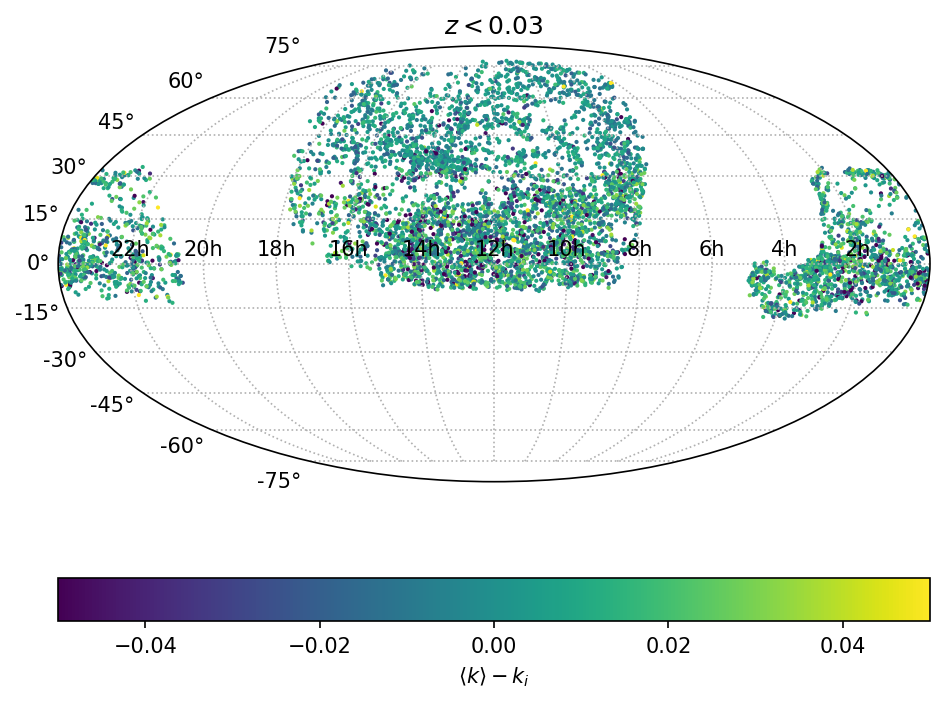

In [27]:
## plot the residuals on a sky plot
from astropy.coordinates import SkyCoord, Distance
lowz_coords = SkyCoord(ra=lowz['RA'], 
                            dec=lowz['DEC'], 
                            unit=u.degree)
midz_coords = SkyCoord(ra=midz['RA'], 
                            dec=midz['DEC'], 
                            unit=u.degree)
highz_coords = SkyCoord(ra=highz['RA'], 
                            dec=highz['DEC'], 
                            unit=u.degree)

fig, ax = plt.subplots(tight_layout=True, subplot_kw={'projection' : 'mollweide'}, dpi=150)

ra_lowz = np.radians(180*u.deg - lowz_coords.ra)
dec_lowz = np.radians(lowz_coords.dec)

sc = ax.scatter(ra_lowz, dec_lowz,
                c=lowz['k_res'],  # colored by residual
                s=1,
                vmin=-0.05,
                vmax=0.05
               )

# Add a colorbar
cb = plt.colorbar(sc, ax=ax, orientation='horizontal')
cb.set_label(r'$\langle k \rangle - k_i$')


ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');
ax.set(title=r'$z < 0.03$')


[Text(0.5, 1.0, '$0.03< z < 0.05$')]

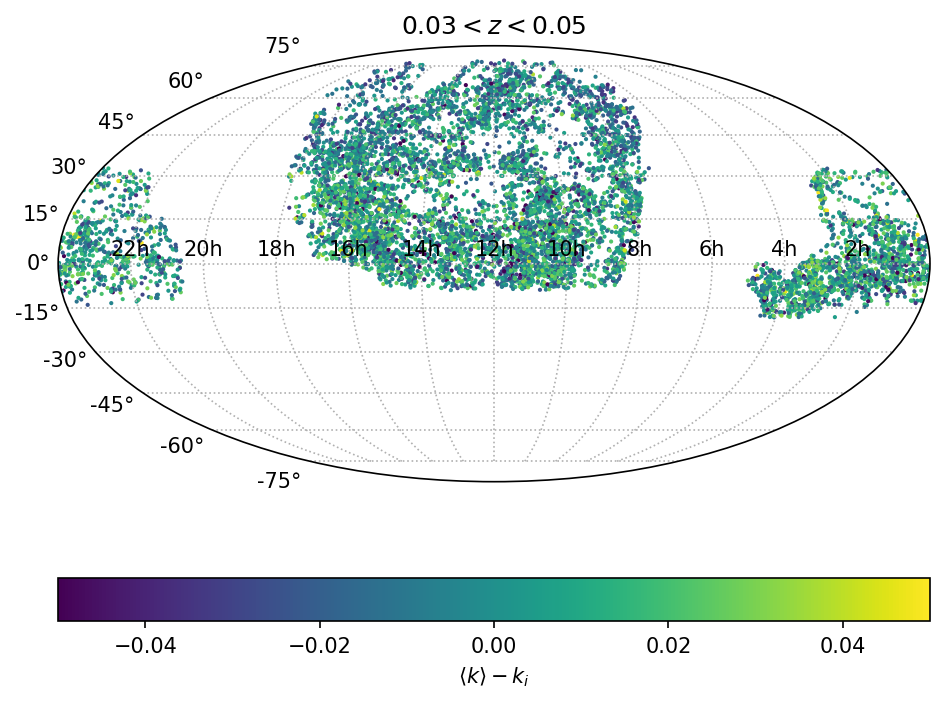

In [28]:
## repeat for mid and high z

fig, ax = plt.subplots(tight_layout=True, subplot_kw={'projection' : 'mollweide'}, dpi=150)

ra_midz = np.radians(180*u.deg - midz_coords.ra)
dec_midz = np.radians(midz_coords.dec)

sc = ax.scatter(ra_midz, dec_midz,
                c=midz['k_res'],  # colored by residual
                s=1,
                vmin=-0.05,
                vmax=0.05
               )

# Add a colorbar
cb = plt.colorbar(sc, ax=ax, orientation='horizontal')
cb.set_label(r'$\langle k \rangle - k_i$')


ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');
ax.set(title=r'$0.03< z < 0.05$')

[Text(0.5, 1.0, '$0.05< z < 0.1$')]

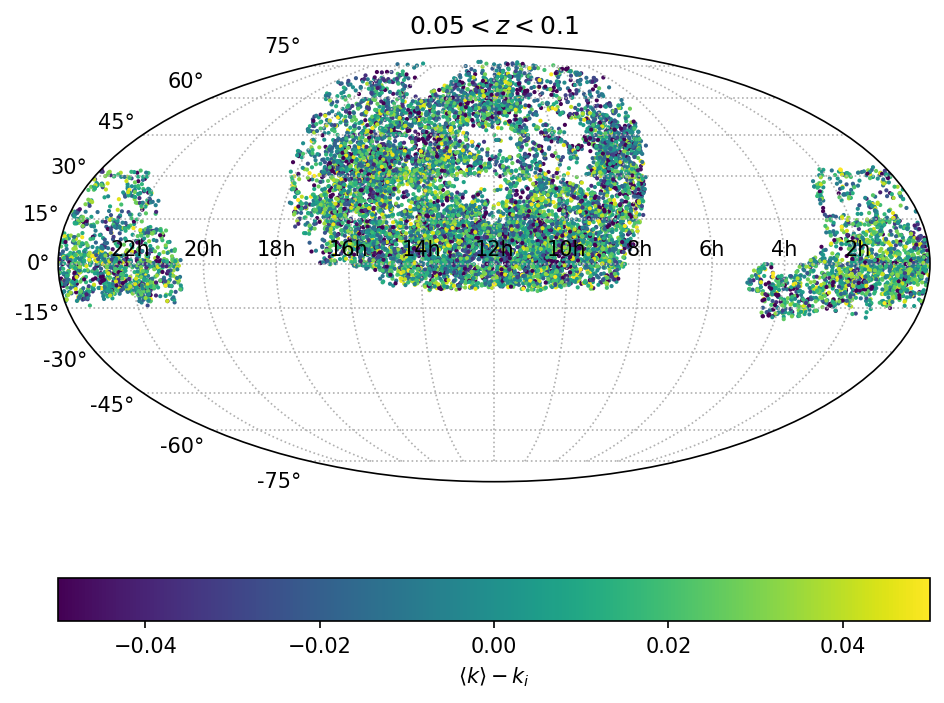

In [29]:
fig, ax = plt.subplots(tight_layout=True, subplot_kw={'projection' : 'mollweide'}, dpi=150)

ra_highz = np.radians(180*u.deg - highz_coords.ra)
dec_highz = np.radians(highz_coords.dec)

sc = ax.scatter(ra_highz, dec_highz,
                c=highz['k_res'],  # colored by residual
                s=1,
                vmin=-0.05,
                vmax=0.05
               )

# Add a colorbar
cb = plt.colorbar(sc, ax=ax, orientation='horizontal')
cb.set_label(r'$\langle k \rangle - k_i$')


ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');
ax.set(title=r'$0.05< z < 0.1$')

### Internal dust extinction correction

This is based off of a linear fit to ($b/a$, $m_r$), removing any correlation between $b/a$ and $m_r$.

In [18]:
temp_infile = open('../jura_internalDust_z0p1_mcmc.pickle', 'rb')
# temp_infile = open('jura_internalDust_nokcorr_mcmc.pickle', 'rb')
dust_mcmc_samples_r,_, dust_mcmc_samples_g,_, dust_mcmc_samples_z,_ = pickle.load(temp_infile)
temp_infile.close()

In [19]:
internalDust_coeffs_r = np.median(dust_mcmc_samples_r, axis=1)
internalDust_coeffs_g = np.median(dust_mcmc_samples_g, axis=1)
internalDust_coeffs_z = np.median(dust_mcmc_samples_z, axis=1)

internalDust_coeffs_err_r = np.zeros(len(internalDust_coeffs_r))
internalDust_coeffs_err_g = np.zeros(len(internalDust_coeffs_g))
internalDust_coeffs_err_z = np.zeros(len(internalDust_coeffs_z))

internalDust_coeffs_err_r[0] = np.std(dust_mcmc_samples_r[0][(-1.5 < dust_mcmc_samples_r[0]) & (dust_mcmc_samples_r[0] < 0)])
internalDust_coeffs_err_r[1] = np.std(dust_mcmc_samples_r[1][(0 < dust_mcmc_samples_r[1]) & (dust_mcmc_samples_r[1] < 1)])

internalDust_coeffs_err_g[0] = np.std(dust_mcmc_samples_g[0][(-1.5 < dust_mcmc_samples_g[0]) & (dust_mcmc_samples_g[0] < 0)])
internalDust_coeffs_err_g[1] = np.std(dust_mcmc_samples_g[1][(0 < dust_mcmc_samples_g[1]) & (dust_mcmc_samples_g[1] < 1)])

internalDust_coeffs_err_z[0] = np.std(dust_mcmc_samples_z[0][(-1.5 < dust_mcmc_samples_z[0]) & (dust_mcmc_samples_z[0] < 0)])
internalDust_coeffs_err_z[1] = np.std(dust_mcmc_samples_z[1][(0 < dust_mcmc_samples_z[1]) & (dust_mcmc_samples_z[1] < 1)])

In [20]:
internalDust_corr_r, internalDust_corr_err_r = internal_dust(SGA_TF['BA'], 
                                                             internalDust_coeffs_r, 
                                                             internalDust_coeffs_err_r)

internalDust_corr_g, internalDust_corr_err_g = internal_dust(SGA_TF['BA'], 
                                                             internalDust_coeffs_g, 
                                                             internalDust_coeffs_err_g)

internalDust_corr_z, internalDust_corr_err_z = internal_dust(SGA_TF['BA'], 
                                                             internalDust_coeffs_z, 
                                                             internalDust_coeffs_err_z)

### Apply corrections

In [21]:
SGA_TF['G_MAG_SB26_CORR'] = SGA_TF['G_MAG_SB26'] - MWdust_corr[0] + sys_corr + kcorr[:,0] - internalDust_corr_g
SGA_TF['R_MAG_SB26_CORR'] = SGA_TF['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr_r
SGA_TF['Z_MAG_SB26_CORR'] = SGA_TF['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr + kcorr[:,2] - internalDust_corr_z

In [22]:
# SGA_TF['RK_MAG_SB26_CORR'] = SGA_TF['R_MAG_SB26'] - MWdust_corr[1] + sys_corr + kcorr[:,1] - internalDust_corr_r

In [55]:
# SGA_TF['G_MAG_SB26_CORR'] = SGA_TF['G_MAG_SB26'] - MWdust_corr[0] + sys_corr - internalDust_corr_g
# SGA_TF['R_MAG_SB26_CORR'] = SGA_TF['R_MAG_SB26'] - MWdust_corr[1] + sys_corr - internalDust_corr_r
# SGA_TF['Z_MAG_SB26_CORR'] = SGA_TF['Z_MAG_SB26'] - MWdust_corr[2] + sys_corr - internalDust_corr_z

In [28]:
SGA_TF['G_MAG_SB26_ERR_CORR'] = np.sqrt(SGA_TF['G_MAG_SB26_ERR']**2 + MWdust_corr_err[0]**2 + sys_corr_err**2 + internalDust_corr_err_g**2)
SGA_TF['R_MAG_SB26_ERR_CORR'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR']**2 + MWdust_corr_err[1]**2 + sys_corr_err**2 + internalDust_corr_err_r**2)
SGA_TF['Z_MAG_SB26_ERR_CORR'] = np.sqrt(SGA_TF['Z_MAG_SB26_ERR']**2 + MWdust_corr_err[2]**2 + sys_corr_err**2 + internalDust_corr_err_z**2)

## Compute the absolute magnitudes based on the redshift

In [29]:
cosmo = FlatLambdaCDM(H0=H0, Om0=0.3151)

SGA_TF['MU_ZCMB'] = cosmo.distmod(SGA_TF['Z_DESI_CMB'])

SGA_TF['R_ABSMAG_SB26'] = SGA_TF['R_MAG_SB26_CORR'] - SGA_TF['MU_ZCMB'].value
SGA_TF['G_ABSMAG_SB26'] = SGA_TF['G_MAG_SB26_CORR'] - SGA_TF['MU_ZCMB'].value
SGA_TF['Z_ABSMAG_SB26'] = SGA_TF['Z_MAG_SB26_CORR'] - SGA_TF['MU_ZCMB'].value

In [30]:
rng = np.random.default_rng()

N_samples = 1000

mu_err = np.empty(len(SGA_TF['MU_ZCMB']))*u.mag

for i in tqdm(range(len(mu_err))):
    
    z_desi_random = rng.normal(np.abs(SGA_TF['Z_DESI_CMB'][i]), 
                               SGA_TF['ZERR_DESI'][i], 
                               N_samples)
    
    mu_random = cosmo.distmod(z_desi_random)
    
    mu_err[i] = np.std(mu_random)

SGA_TF['MU_ZCMB_ERR'] = mu_err

100%|██████████| 35607/35607 [00:36<00:00, 986.85it/s] 


In [31]:
SGA_TF['R_ABSMAG_SB26_ERR'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR_CORR']**2 + SGA_TF['MU_ZCMB_ERR'].value**2)
SGA_TF['G_ABSMAG_SB26_ERR'] = np.sqrt(SGA_TF['G_MAG_SB26_ERR_CORR']**2 + SGA_TF['MU_ZCMB_ERR'].value**2)
SGA_TF['Z_ABSMAG_SB26_ERR'] = np.sqrt(SGA_TF['Z_MAG_SB26_ERR_CORR']**2 + SGA_TF['MU_ZCMB_ERR'].value**2)

## Identify outliers

See the `TF_Y1_clustering.ipynb` notebook for details.

In [32]:
r_data = np.array([SGA_TF['R_ABSMAG_SB26'], np.log10(SGA_TF['V_0p4R26'])])
g_data = np.array([SGA_TF['G_ABSMAG_SB26'], np.log10(SGA_TF['V_0p4R26'])])
z_data = np.array([SGA_TF['Z_ABSMAG_SB26'], np.log10(SGA_TF['V_0p4R26'])])

clusterer = HDBSCAN(cluster_selection_epsilon=0.04)

clusterer.fit(r_data.T)
r_outlier_boolean = clusterer.labels_ != 54
# r_outlier_boolean = clusterer.labels_ != 51 #no k-corr

clusterer.fit(g_data.T)
g_outlier_boolean = clusterer.labels_ != 50
# g_outlier_boolean = clusterer.labels_ != 58 #no k-corr

clusterer.fit(z_data.T)
z_outlier_boolean = clusterer.labels_ != 59 #same in both cases

## if we want the population to be galaxies in any of the bulk populations
# outlier_boolean_2 = (r_outlier_boolean & g_outlier_boolean & z_outlier_boolean) 

## Only use galaxies that are in bulk cluster in all bands
outlier_boolean = ~(~r_outlier_boolean & ~g_outlier_boolean & ~z_outlier_boolean)
outlier_boolean_alt = (r_outlier_boolean & g_outlier_boolean & z_outlier_boolean)

SGA_TF['OUTLIER'] = outlier_boolean

# TFR

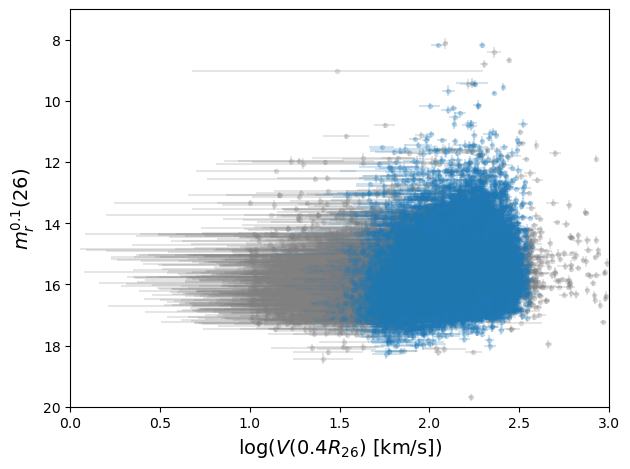

In [33]:
plt.figure(tight_layout=True)

sample = outlier_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['R_MAG_SB26_CORR'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['R_MAG_SB26_ERR_CORR'][sample], 
             color='gray',
             fmt='.', 
             alpha=0.2)

sample = ~outlier_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['R_MAG_SB26_CORR'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['R_MAG_SB26_ERR_CORR'][sample], 
             fmt='.', 
             alpha=0.2)

plt.xlim([0, 3])
plt.ylim([20, 7])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$m_r^{0.1} (26)$', fontsize=14);

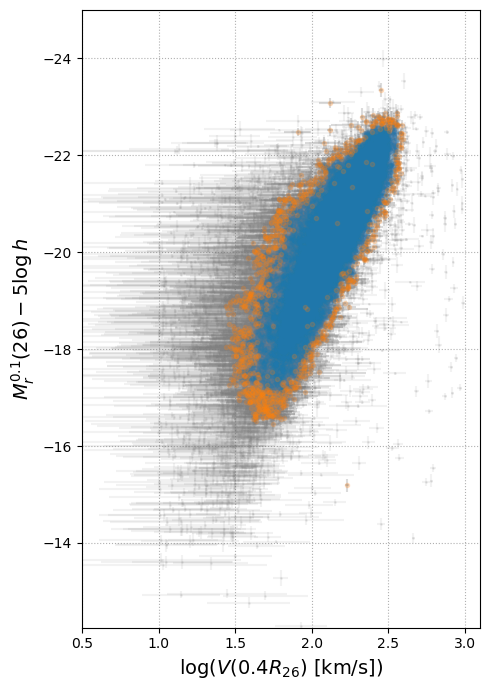

In [34]:
plt.figure(figsize=(5,7), tight_layout=True)

plt.grid(ls=':')

sample = outlier_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['R_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['R_ABSMAG_SB26_ERR'][sample], 
             fmt='.', 
             ms=2,
             color='gray',
             alpha=0.1, 
             ecolor='gray')

sample = ~outlier_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['R_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['R_ABSMAG_SB26_ERR'][sample], 
             fmt='.', 
             alpha=0.1, 
             ecolor='gray')

sample = ~outlier_boolean_alt & outlier_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['R_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['R_ABSMAG_SB26_ERR'][sample], 
             fmt='.', 
             alpha=0.2, 
             ecolor='gray')

plt.xlim([0.5, 3.1])
plt.ylim([-12.25, -25])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26) - 5\log h$', fontsize=14);

## Plotted with our TFR

### Calibration without dwarfs

Here, $V_0$, the slope, and the y-intercepts are from `TF_Y1_zbin_calibration_weightsVmax-1_HDBSCAN_KAD.ipynb`:

\begin{equation}
  M_r = a \log\left(\frac{V(0.4R_{26})}{V_0}\right) + B(z_c)
\end{equation}

where $B(z_c) = b(z_c) - \mu(z_c)$, where $z_c$ is the center redshift of the relevant redshift bin.

In [35]:
temp_infile = open('/pscratch/sd/s/sgmoore1/TF/pickles/Y3/cov_ab_jura_jointTFR_HDBSCAN_r_v1.pickle', 
                   'rb')
r_cov_ab, r_tfr_samples, logV0, zmin, zmax, dz, zbins = pickle.load(temp_infile)
temp_infile.close()

In [30]:
# clusterer = HDBSCAN(cluster_selection_epsilon=0.04)
# clusterer.fit(r_data.T)
# outlier_boolean = clusterer.labels_ != 53


In [36]:
# Center redshift values of each bin
zc = 0.5*dz + zbins[:-1]

# Distance modulus for each redshift bin center
mu_zc = cosmo.distmod(zc)

In [37]:
r_slope = np.median(r_tfr_samples[0])
r_slope_err = np.sqrt(r_cov_ab[0,0])

# Each redshift bin has its own 0pt
# To put it in absolute-magnitude space, we'll convert it to an absolute magnitude using the middle of the redshift bin
r_ZP = np.median(r_tfr_samples[1:-1], axis=1) - mu_zc.value
r_ZP_err = np.sqrt(np.diagonal(r_cov_ab[1:-1,1:-1])) # Should include z-bin width to this uncertainty

r_sig = np.median(r_tfr_samples[-1])

logv = np.linspace(-1*np.ones(len(zbins)-1), 3.5*np.ones(len(zbins)-1), 100)
r_absmag = r_slope*(logv - logV0) + r_ZP

In [46]:
print(r_slope)
print(r_slope_err)
print(r_sig)
print(np.sqrt(r_cov_ab[-1,-1]))

-6.639112978358142
0.0027583349585843186
0.3955532056245733
0.00023526584718629694


In [33]:
# This cell needs to be updated for each redshift bin
'''
# Calculate the uncertainties in the calibrated TFR
slopes = tfr_samples[0]
ZPs = tfr_samples[1:-1]

N_samples = len(slopes)

lines = []

for i in range(N_samples):
    # Transform zero-points
    
    lines.append(slopes[i]*(logv - V0) + ZPs[i])
    
lines_array = np.asarray(lines)
line_err = np.nanpercentile(lines_array, [16 ,84], axis=0)
''';

In [47]:
spiral_boolean = SGA_TF['MORPHTYPE_AI'] == 'Spiral'
irregular_boolean = SGA_TF['MORPHTYPE_AI'] == 'Irregular'
# other_boolean = SGA_TF['MORPHTYPE_AI'] == 'Other'

VI_boolean = SGA_TF['JOHN_VI'].mask

morph_boolean = (spiral_boolean | irregular_boolean) & VI_boolean

In [48]:
SGA_TF['GOOD_MORPH'] = morph_boolean

print(sum(outlier_boolean), 'outliers')
print(sum(~outlier_boolean), 'non-outliers')
print('-----------')
print(np.sum(morph_boolean), 'spirals & irregulars that pass VI')
print(np.sum(morph_boolean & outlier_boolean), 'outliers')
print(np.sum(morph_boolean & ~outlier_boolean), 'non-outliers')

2879 outliers
32728 non-outliers
-----------
32462 spirals & irregulars that pass VI
2275 outliers
30187 non-outliers


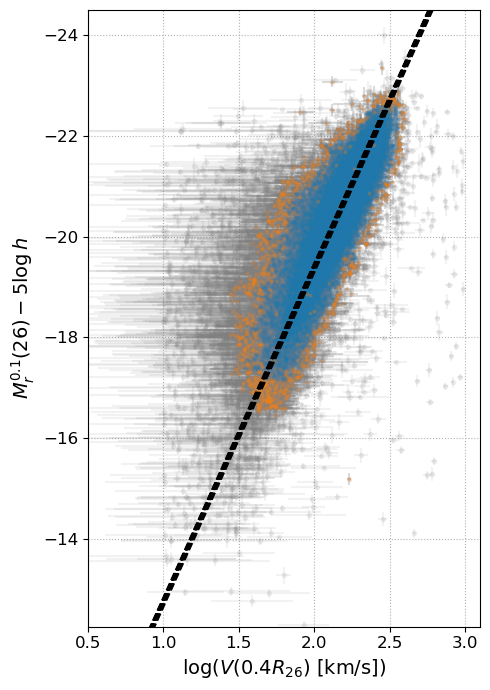

In [49]:
plt.figure(figsize=(5,7), tight_layout=True)

plt.grid(ls=':')

# plt.fill_between(logv, line_err[0], line_err[1], color='lightgray')

sample = outlier_boolean# & morph_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['R_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['R_ABSMAG_SB26_ERR'][sample], 
             fmt='.',
             color='gray',
             alpha=0.1, 
             ecolor='gray')

sample = ~outlier_boolean# & morph_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['R_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['R_ABSMAG_SB26_ERR'][sample], 
             fmt='.', 
             markersize=4, 
             alpha=0.1, 
             ecolor='gray')

sample = ~outlier_boolean_alt & outlier_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['R_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['R_ABSMAG_SB26_ERR'][sample], 
             fmt='.', 
             markersize=4, 
             alpha=0.2, 
             ecolor='gray')



plt.plot(logv, r_absmag, 'k--', zorder=3)

plt.xlim([0.5, 3.1])
plt.ylim([-12.25, -24.5])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26) - 5\log h$', fontsize=14);

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12);

plt.savefig('/pscratch/sd/s/sgmoore1/TF/figures/tfr_scatter_fit_R.png', 
            dpi=150, 
            facecolor='none')

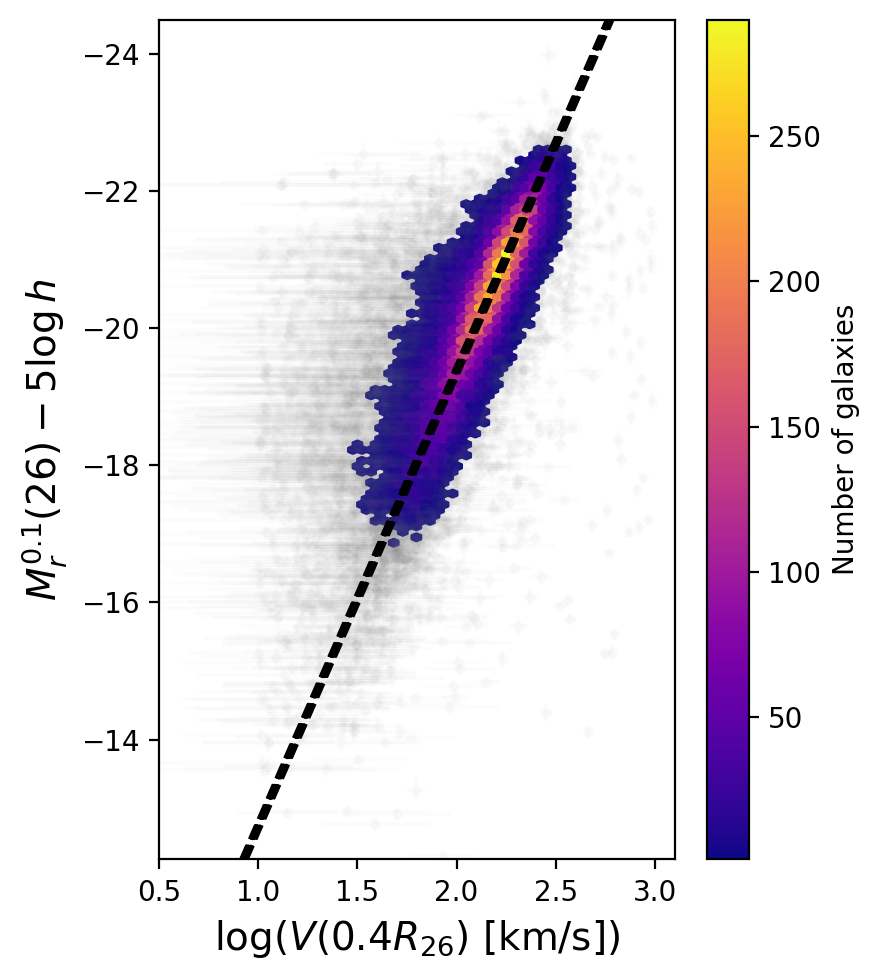

In [37]:
plt.figure(figsize=(4.5,5), tight_layout=True, dpi=200)

sample = outlier_boolean# & morph_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['R_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['R_ABSMAG_SB26_ERR'][sample], 
             fmt='.',
             color='gray',
             alpha=0.02, 
             ecolor='gray')

sample = ~outlier_boolean 
plt.hexbin(np.log10(SGA_TF['V_0p4R26'][sample]), 
           SGA_TF['R_ABSMAG_SB26'][sample], 
           cmap='plasma', 
           mincnt=1, 
           gridsize=(70,80), 
           extent=(-0.1, 3.1, -25, -12.25))
plt.colorbar(label='Number of galaxies')

# plt.fill_between(logv, line_err[0], line_err[1], color='lightgray', alpha=0.2)
plt.plot(logv, r_absmag, 'k--', zorder=3)

plt.xlim([0.5, 3.1])
plt.ylim([-12.25, -24.5])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_r^{0.1} (26) - 5\log h$', fontsize=14);

plt.savefig('/pscratch/sd/s/sgmoore1/TF/figures/tfr_hexplot_Y3_HDBSCAN_R.png',
            dpi=150, 
            facecolor='none',);

In [38]:
# plt.figure(figsize=(4.5,5), tight_layout=True)

# plt.hist2d(np.log10(SGA_TF['V_0p4R26'][~outlier_boolean]), 
#            SGA_TF['R_ABSMAG_SB26'][~outlier_boolean], 
#            bins=[np.arange(0.5,3.1,0.05), np.arange(-24, -11.9, 0.1)], 
#            cmap='CMRmap_r')
# plt.colorbar(label='Number of galaxies')

# # plt.fill_between(logv, line_err[0], line_err[1], color='lightgray', alpha=0.2)
# plt.plot(logv, r_absmag, 'k--', zorder=3)

# plt.xlim([1.5, 2.75])
# plt.ylim([-17, -23])

# plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
# plt.ylabel('$M_r^{0.1} (26)$', fontsize=14);

#### Redshift distribution

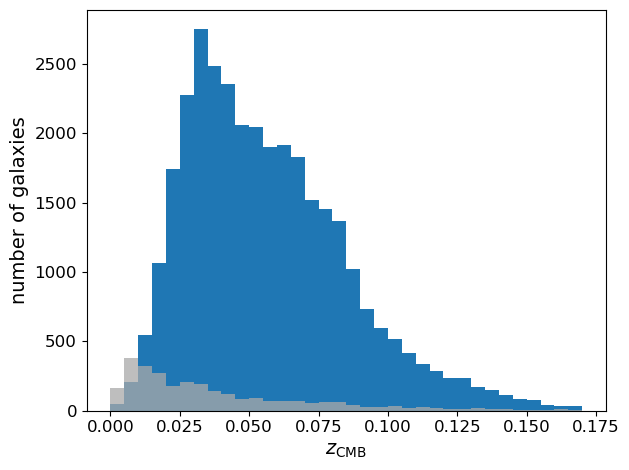

In [39]:
plt.figure(tight_layout=True)

plt.hist(SGA_TF['Z_DESI_CMB'][~outlier_boolean],
         bins=np.arange(0, 0.175, 0.005))
plt.hist(SGA_TF['Z_DESI_CMB'][outlier_boolean],
         bins=np.arange(0, 0.175, 0.005), 
         color='darkgray',
         alpha=0.75)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel('number of galaxies', fontsize=14);

# Distance moduli

In [40]:
# First, match each galaxy to its redshift bin
zbin_indices = np.digitize(SGA_TF['Z_DESI_CMB'], zbins, right=True)

# For those galaxies that fall outside the calibration range, assign them to the closest bin
zbin_indices[zbin_indices == 0] = 1
zbin_indices[zbin_indices == len(zbins)] = len(zbins) - 1

# Then, use that galaxy's redshift bin's zero-point to calculate the distance modulus
SGA_TF['R_ABSMAG_SB26_TF'] = np.nan
for i in range(len(SGA_TF)):
    SGA_TF['R_ABSMAG_SB26_TF'][i] = r_slope*(np.log10(SGA_TF['V_0p4R26'][i]) - logV0) + r_ZP[zbin_indices[i] - 1]

In [41]:
SGA_TF['R_ABSMAG_SB26_TF_ERR'] = np.nan
SGA_TF['R_ABSMAG_SB26_TF_ERR_STAT'] = np.nan

rng = np.random.default_rng()

for i in tqdm(range(len(SGA_TF))):
    
    v_random = rng.normal(SGA_TF['V_0p4R26'][i], 
                          SGA_TF['V_0p4R26_ERR'][i], 
                          size=10000
                          # size=len(slopes)
                         )
    # logv_random = rng.normal(np.log10(SGA_TF['V_0p4R26'][i]), 
    #                          0.434*SGA_TF['V_0p4R26_ERR'][i]/SGA_TF['V_0p4R26'][i], 
    #                          size=len(slopes))

    ############################################################################
    # Statistical uncertainty
    #---------------------------------------------------------------------------
    Ms_stat = r_slope*(np.log10(v_random[v_random > 0]) - logV0) + r_ZP[zbin_indices[i] - 1]
    # Ms_stat = slope*(logv_random - V0) + ZP

    SGA_TF['R_ABSMAG_SB26_TF_ERR_STAT'][i] = np.nanstd(Ms_stat)
    ############################################################################

    
    ############################################################################
    # Total uncertainty
    #
    # THIS NEEDS TO BE UPDATED TO INCLUDE THE SLOPE & Y-INTERCEPT UNCERTAINTIES
    #---------------------------------------------------------------------------
    # Ms = slopes[v_random > 0]*(np.log10(v_random[v_random > 0]) - V0) + ZPs[v_random > 0]
    # Ms = slopes*(logv_random - V0) + ZPs
    
    # SGA_TF['R_ABSMAG_SB26_TF_ERR'][i] = np.nanstd(Ms)
    SGA_TF['R_ABSMAG_SB26_TF_ERR'][i] = np.sqrt(SGA_TF['R_ABSMAG_SB26_TF_ERR_STAT'][i]**2 + r_sig**2)
    ############################################################################
    

################################################################################
# Systematic uncertainty
#-------------------------------------------------------------------------------
SGA_TF['R_ABSMAG_SB26_TF_ERR_SYS'] = np.sqrt(SGA_TF['R_ABSMAG_SB26_TF_ERR']**2 - SGA_TF['R_ABSMAG_SB26_TF_ERR_STAT']**2)
################################################################################

100%|██████████| 35607/35607 [00:13<00:00, 2617.31it/s]


In [42]:
def profile_histogram(x, y, xbins, yerr=None, weights=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        If not None (and weighted=True), will use this instead of yerr to weight 
        the summary statistics.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Weight the summary statistics, either by the uncertainty in y or the 
        provided weights.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if (yerr is None) and (weights is None):
            raise ValueError('need to define either yerr or weights if using weighted fit.')

        if weights is None:
            # weight based on yerr
            w = 1/yerr**2
        else:
            w = weights
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

/tmp/ipykernel_1624633/3818747994.py:50: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt((mean2 - mean**2) / (N - 1))


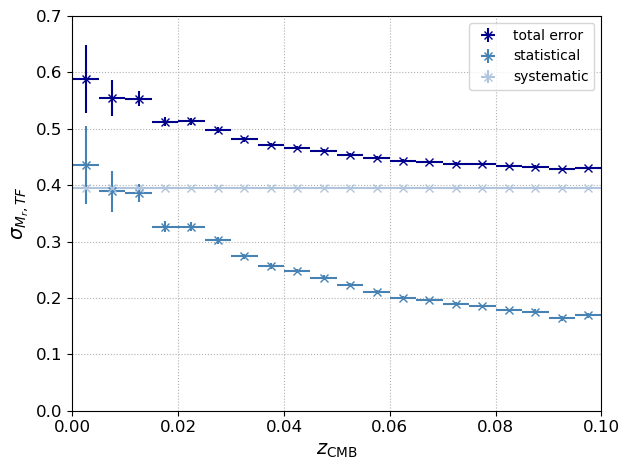

In [43]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~outlier_boolean
sample2 = outlier_boolean

plt.figure(tight_layout=True)

# plt.plot(tf_data['Z_DESI_CMB'][sample1], tf_data['R_ABSMAG_SB26_TF_ERR'][sample1], '.', alpha=0.1)

# Total uncertainty
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['R_ABSMAG_SB26_TF_ERR'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='total error')

# Statistical uncertainty (just from velocity uncertainty)
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['R_ABSMAG_SB26_TF_ERR_STAT'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='steelblue', label='statistical')

# Systematic uncertainty (from TF calibration)
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['R_ABSMAG_SB26_TF_ERR_SYS'][sample1], 
                                    zbins, 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='lightsteelblue', label='systematic')

plt.grid(ls=':')

plt.legend()

plt.xlim(0, 0.1)
plt.ylim(0, 0.7)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\sigma_{M_r, TF}$', fontsize=14);

## Compute distance modulus based on our TFR

In [44]:
SGA_TF['R_MU_TF'] = SGA_TF['R_MAG_SB26_CORR'] - SGA_TF['R_ABSMAG_SB26_TF']

SGA_TF['R_MU_TF_ERR'] = np.sqrt(SGA_TF['R_MAG_SB26_ERR_CORR']**2 + SGA_TF['R_ABSMAG_SB26_TF_ERR']**2)

## $\Delta M_r$ v. redshift

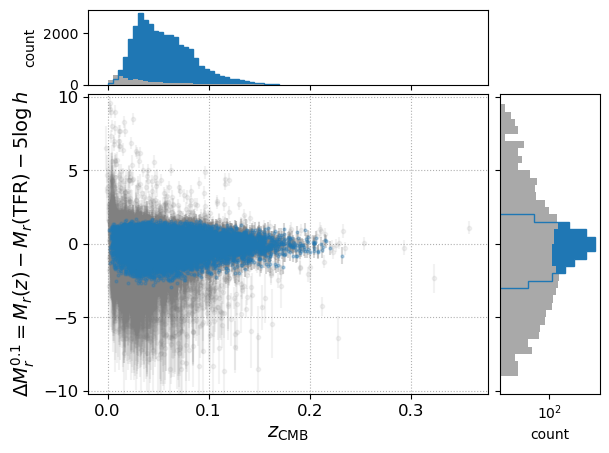

In [45]:
fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])

sample = outlier_boolean# & morph_boolean
ax.errorbar(SGA_TF['Z_DESI_CMB'][sample], 
             SGA_TF['R_ABSMAG_SB26'][sample] - SGA_TF['R_ABSMAG_SB26_TF'][sample], 
             xerr=SGA_TF['ZERR_DESI'][sample], 
             yerr=SGA_TF['R_MU_TF_ERR'][sample],
             fmt='.', 
             color='gray',
             alpha=0.1, 
             ecolor='gray')

sample = ~outlier_boolean
ax.errorbar(SGA_TF['Z_DESI_CMB'][sample], 
             SGA_TF['R_ABSMAG_SB26'][sample] - SGA_TF['R_ABSMAG_SB26_TF'][sample], 
             xerr=SGA_TF['ZERR_DESI'][sample], 
             yerr=SGA_TF['R_MU_TF_ERR'][sample],
             fmt='.', 
             markersize=4, 
             alpha=0.3, 
             ecolor='gray')

ax.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=14)
ax.set_ylabel(r'$\Delta M_r^{0.1} = M_r(z) - M_r(\text{TFR}) - 5\log h$', fontsize=14)

ax.set_ylim((-10.2, 10.2))


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(SGA_TF['Z_DESI_CMB'][~outlier_boolean],
              bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(SGA_TF['Z_DESI_CMB'][outlier_boolean],
              bins=np.arange(0, 0.175, 0.005), 
              color='darkgray')
ax_histx.hist(SGA_TF['Z_DESI_CMB'][~outlier_boolean],
              bins=np.arange(0, 0.175, 0.005), 
              color='tab:blue', 
              histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('count')


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
sample1 = ~outlier_boolean
sample2 = outlier_boolean
ax_histy.hist(SGA_TF['R_ABSMAG_SB26'][sample1] - SGA_TF['R_ABSMAG_SB26_TF'][sample1], 
              bins=np.arange(-12.5, 10, 0.5), 
              orientation='horizontal')
ax_histy.hist(SGA_TF['R_ABSMAG_SB26'][sample2] - SGA_TF['R_ABSMAG_SB26_TF'][sample2], 
              bins=np.arange(-12.5, 10, 0.5), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(SGA_TF['R_ABSMAG_SB26'][sample1] - SGA_TF['R_ABSMAG_SB26_TF'][sample1], 
              bins=np.arange(-12.5, 10, 0.5), 
              orientation='horizontal', 
              histtype='step', 
              color='tab:blue')

ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.set_xlabel('count');

## $\eta$ v. redshift

In [46]:
SGA_TF['R_LOGDIST'] = 0.2*(SGA_TF['MU_ZCMB'] - SGA_TF['R_MU_TF'])
SGA_TF['R_LOGDIST_ERR'] = 0.2*np.sqrt(SGA_TF['MU_ZCMB_ERR']**2 + SGA_TF['R_MU_TF_ERR']**2)

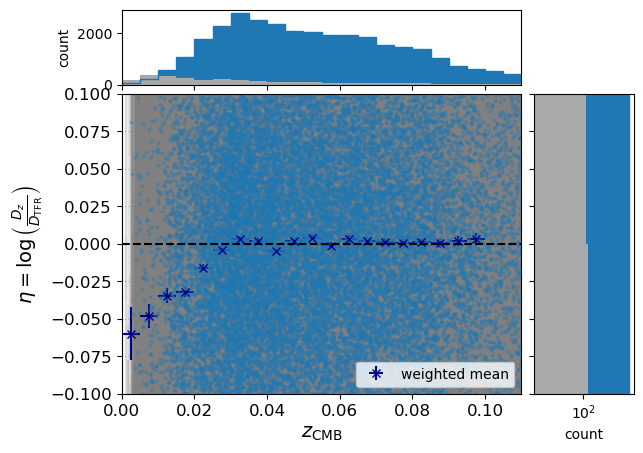

In [47]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~outlier_boolean
sample2 = outlier_boolean

fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])

ax.errorbar(SGA_TF['Z_DESI_CMB'][sample2], 
             SGA_TF['R_LOGDIST'][sample2], 
             xerr=SGA_TF['ZERR_DESI'][sample2], 
             yerr=SGA_TF['R_LOGDIST_ERR'][sample2],
             fmt='.', 
             color='gray',
             alpha=0.1, 
             ecolor='gray')

ax.errorbar(SGA_TF['Z_DESI_CMB'][sample1], 
             SGA_TF['R_LOGDIST'][sample1], 
             xerr=SGA_TF['ZERR_DESI'][sample1], 
             yerr=SGA_TF['R_LOGDIST_ERR'][sample1],
             fmt='.', 
             markersize=4, 
             alpha=0.3, 
             ecolor='gray')

# Plot the weighted mean
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['R_LOGDIST'][sample1], 
                                    zbins, 
                                    weights=SGA_TF['R_LOGDIST_ERR'][sample1]**-2, 
                                    weighted=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='weighted mean')
'''
# Plot the median
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['R_LOGDIST'][sample1], 
                                    zbins, 
                                    median=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='lightsteelblue', label='median')
'''
# Line at eta = 0
ax.hlines(0, 0, 0.2, linestyles='dashed', colors='k', zorder=5)

ax.legend()

ax.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=14)
ax.set_ylabel(r'$\eta = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$', fontsize=14)

# ax.set_ylim((-1.9, 1.9))
ax.set_xlim((0, 0.2))
# ax.set_ylim((-0.5, 0.5))
ax.set_ylim((-0.1, 0.1))
ax.set_xlim((0, 0.11))

ax.grid(ls=':')


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(SGA_TF['Z_DESI_CMB'][sample1], 
              bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(SGA_TF['Z_DESI_CMB'][sample2], 
              bins=np.arange(0, 0.175, 0.005), 
              color='darkgray')
ax_histx.hist(SGA_TF['Z_DESI_CMB'][sample1], 
              bins=np.arange(0, 0.175, 0.005), 
              color='tab:blue', 
              histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('count')


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
ax_histy.hist(SGA_TF['R_LOGDIST'][sample1], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal')
ax_histy.hist(SGA_TF['R_LOGDIST'][sample2], 
              bins=np.arange(-2, 2, 0.1), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(SGA_TF['R_LOGDIST'][sample1], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              histtype='step',
              color='tab:blue')

ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.set_xlabel('count');

# plt.savefig('../../Figures/Y1/iron_logdist-v-z_jointTFR-varyV0-perpdwarfs_z0p1_Anthony2_weightsVmax-1_dVsys_20250717.png', 
#             dpi=150, 
#             facecolor='none', 
#             bbox_inches='tight');

In [48]:
y_std

array([0.01761821, 0.00788822, 0.00488105, 0.00332483, 0.00260023,
       0.00221771, 0.00196556, 0.0020274 , 0.00204437, 0.00216333,
       0.00214285, 0.00219584, 0.0021637 , 0.00220147, 0.00239842,
       0.00243413, 0.00249098, 0.00288667, 0.00336187, 0.00372559])

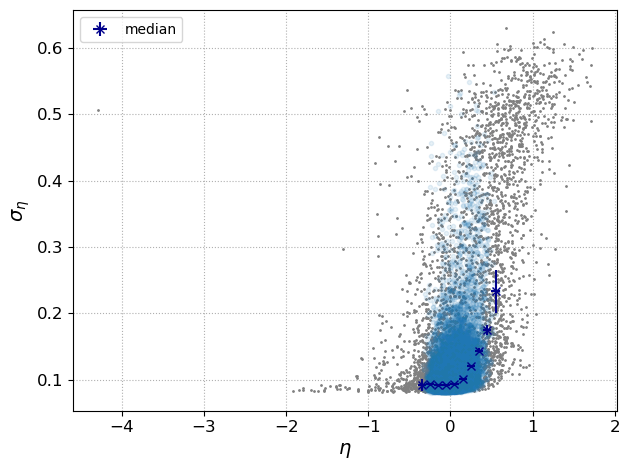

In [49]:
# Any correlation between eta and its uncertainty?
nbins = np.arange(-1.5, 1.5, 0.1)
dn = 0.5*np.diff(nbins)
nc = 0.5*(nbins[1:] + nbins[:-1])

sample1 = ~outlier_boolean
sample2 = outlier_boolean

plt.figure(tight_layout=True)

plt.plot(SGA_TF['R_LOGDIST'][sample2], 
         SGA_TF['R_LOGDIST_ERR'][sample2], 
         '.', ms=2, color='gray')

plt.plot(SGA_TF['R_LOGDIST'][sample1], 
         SGA_TF['R_LOGDIST_ERR'][sample1], 
         '.', alpha=0.1)

# Plot median
N, y_avg, y_std = profile_histogram(SGA_TF['R_LOGDIST'][sample1], 
                                    SGA_TF['R_LOGDIST_ERR'][sample1], 
                                    nbins, 
                                    median=True)
plt.errorbar(nc, y_avg, xerr=dn, yerr=y_std, fmt='x', color='darkblue', label='median')

plt.grid(ls=':')

plt.legend()

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$\eta$', fontsize=14)
plt.ylabel(r'$\sigma_\eta$', fontsize=14);

/tmp/ipykernel_1624633/3818747994.py:45: RuntimeWarning: invalid value encountered in true_divide
  h = H/W
/tmp/ipykernel_1624633/3818747994.py:46: RuntimeWarning: divide by zero encountered in true_divide
  e = 1/np.sqrt(W)


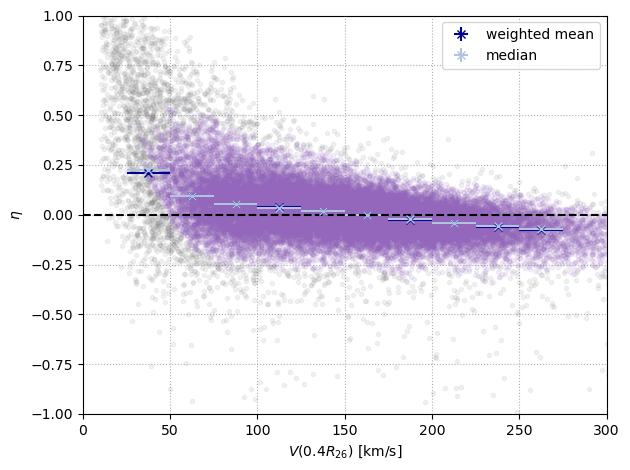

In [50]:
# logv_bins = np.arange(1.75, 2.5, 0.1)
logv_bins = np.arange(0, 300, 25) # These are really linear bins in V
dv = 0.5*np.diff(logv_bins)
vc = 0.5*(logv_bins[1:] + logv_bins[:-1])

plt.figure(tight_layout=True)

plt.grid(ls=':')

# plt.plot(np.log10(SGA_TF['V_0p4R26'][outlier_boolean]), 
plt.plot(SGA_TF['V_0p4R26'][outlier_boolean], 
         SGA_TF['R_LOGDIST'][outlier_boolean], 
         '.', alpha=0.1, c='gray')

# plt.plot(np.log10(SGA_TF['V_0p4R26'][~outlier_boolean]), 
plt.plot(SGA_TF['V_0p4R26'][~outlier_boolean], 
         SGA_TF['R_LOGDIST'][~outlier_boolean], 
         '.', alpha=0.1, c='tab:purple')

# Plot weighted mean
# _, y_avg, y_std = profile_histogram(np.log10(SGA_TF['V_0p4R26'][~outlier_boolean]), 
_, y_avg, y_std = profile_histogram(SGA_TF['V_0p4R26'][~outlier_boolean], 
                                    SGA_TF['R_LOGDIST'][~outlier_boolean], 
                                    logv_bins, 
                                    weights=SGA_TF['R_LOGDIST_ERR'][~outlier_boolean]**-2, 
                                    weighted=True)
plt.errorbar(vc, y_avg, xerr=dv, yerr=y_std, fmt='x', color='darkblue', label='weighted mean')

# Plot median
# _, y_avg, y_std = profile_histogram(np.log10(SGA_TF['V_0p4R26'][~outlier_boolean]), 
_, y_avg, y_std = profile_histogram(SGA_TF['V_0p4R26'][~outlier_boolean], 
                                    SGA_TF['R_LOGDIST'][~outlier_boolean], 
                                    logv_bins, 
                                    median=True)
plt.errorbar(vc, y_avg, xerr=dv, yerr=y_std, fmt='x', color='lightsteelblue', label='median')

plt.hlines(0, 0, 1000, colors='k', linestyles='dashed')

plt.legend()

plt.xlim(0, 300)
plt.ylim(-1, 1)

# plt.xlabel('log($V(0.4R_{26})$)')
plt.xlabel('$V(0.4R_{26})$ [km/s]')
plt.ylabel('$\eta$');

## Hubble diagram

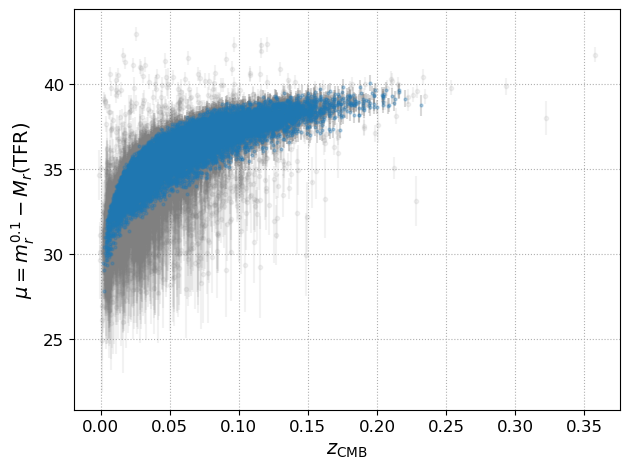

In [51]:
plt.figure(tight_layout=True)

plt.errorbar(SGA_TF['Z_DESI_CMB'][outlier_boolean],
             SGA_TF['R_MU_TF'][outlier_boolean],
             xerr=SGA_TF['ZERR_DESI'][outlier_boolean],
             yerr=SGA_TF['R_MU_TF_ERR'][outlier_boolean],
             fmt='.', 
             color='gray',
             alpha=0.1, 
             ecolor='gray')

plt.errorbar(SGA_TF['Z_DESI_CMB'][~outlier_boolean],
             SGA_TF['R_MU_TF'][~outlier_boolean],
             xerr=SGA_TF['ZERR_DESI'][~outlier_boolean],
             yerr=SGA_TF['R_MU_TF_ERR'][~outlier_boolean],
             fmt='.', 
             markersize=4, 
             alpha=0.3, 
             ecolor='gray')

plt.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\mu = m_r^{0.1} - M_r(\text{TFR})$', fontsize=14);

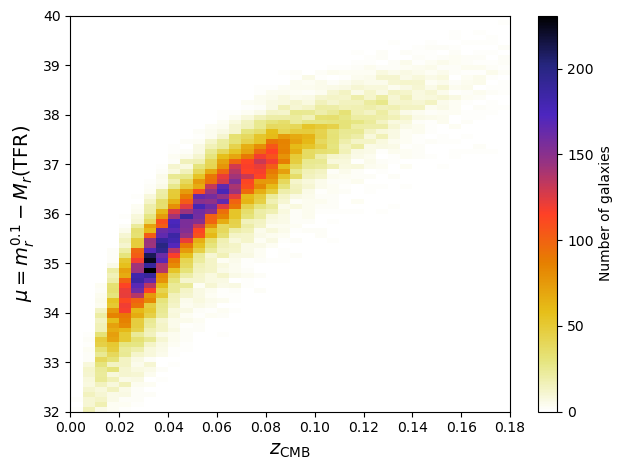

In [52]:
plt.figure(tight_layout=True)

plt.hist2d(SGA_TF['Z_DESI_CMB'][~outlier_boolean], 
           SGA_TF['R_MU_TF'][~outlier_boolean], 
           bins=[np.arange(0,0.35,0.005), np.arange(25, 43, 0.1)],
           cmap='CMRmap_r')
plt.colorbar(label='Number of galaxies')

plt.xlim([0, 0.18])
plt.ylim([32, 40])

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\mu = m_r^{0.1} - M_r(\text{TFR})$', fontsize=14);

# Calculate g-band distance moduli

In [53]:
temp_infile = open('/pscratch/sd/s/sgmoore1/TF/pickles/Y3/cov_ab_jura_jointTFR_HDBSCAN_g_v1.pickle', 
                   'rb')
g_cov_ab, g_tfr_samples, logV0, zmin, zmax, dz, zbins = pickle.load(temp_infile)
temp_infile.close()

In [54]:
g_slope = np.median(g_tfr_samples[0])
g_slope_err = np.sqrt(g_cov_ab[0,0])

# Each redshift bin has its own 0pt
# To put it in absolute-magnitude space, we'll convert it to an absolute magnitude using the middle of the redshift bin
g_ZP = np.median(g_tfr_samples[1:-1], axis=1) - mu_zc.value
g_ZP_err = np.sqrt(np.diagonal(g_cov_ab[1:-1,1:-1])) # Should include z-bin width to this uncertainty

g_sig = np.median(g_tfr_samples[-1])

logv = np.linspace(-1*np.ones(len(zbins)-1), 3.5*np.ones(len(zbins)-1), 100)
g_absmag = g_slope*(logv - logV0) + g_ZP

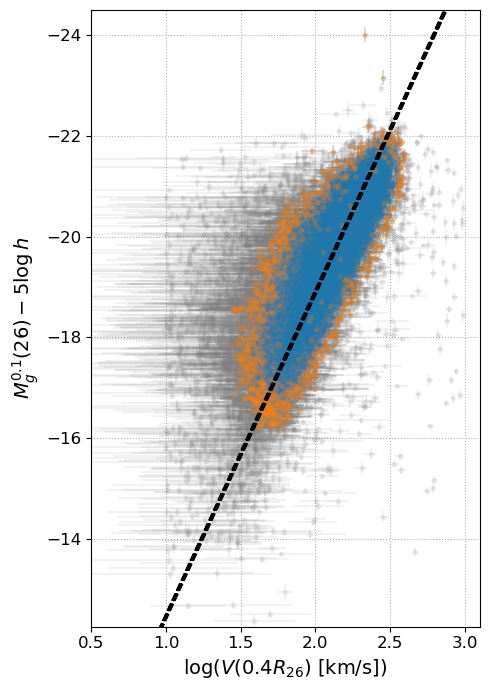

In [55]:
plt.figure(figsize=(5,7), tight_layout=True)

plt.grid(ls=':')

# plt.fill_between(logv, line_err[0], line_err[1], color='lightgray')

sample = outlier_boolean# & morph_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['G_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['G_ABSMAG_SB26_ERR'][sample], 
             fmt='.',
             color='gray',
             alpha=0.1, 
             ecolor='gray')

sample = ~outlier_boolean# & morph_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['G_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['G_ABSMAG_SB26_ERR'][sample], 
             fmt='.', 
             markersize=4, 
             alpha=0.1, 
             ecolor='gray')

sample = ~outlier_boolean_alt & outlier_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['G_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['G_ABSMAG_SB26_ERR'][sample], 
             fmt='.', 
             alpha=0.2, 
             ecolor='gray')

plt.plot(logv, g_absmag, 'k--', zorder=3)

plt.xlim([0.5, 3.1])
plt.ylim([-12.25, -24.5])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_g^{0.1} (26) - 5\log h$', fontsize=14);

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../Figures/Y1/iron_jointTFR_varyV0-perpdwarf_z0p1_Anthony2_weightsVmax-1_dVsys_20250717.png', 
#             dpi=150, 
#             facecolor='none')

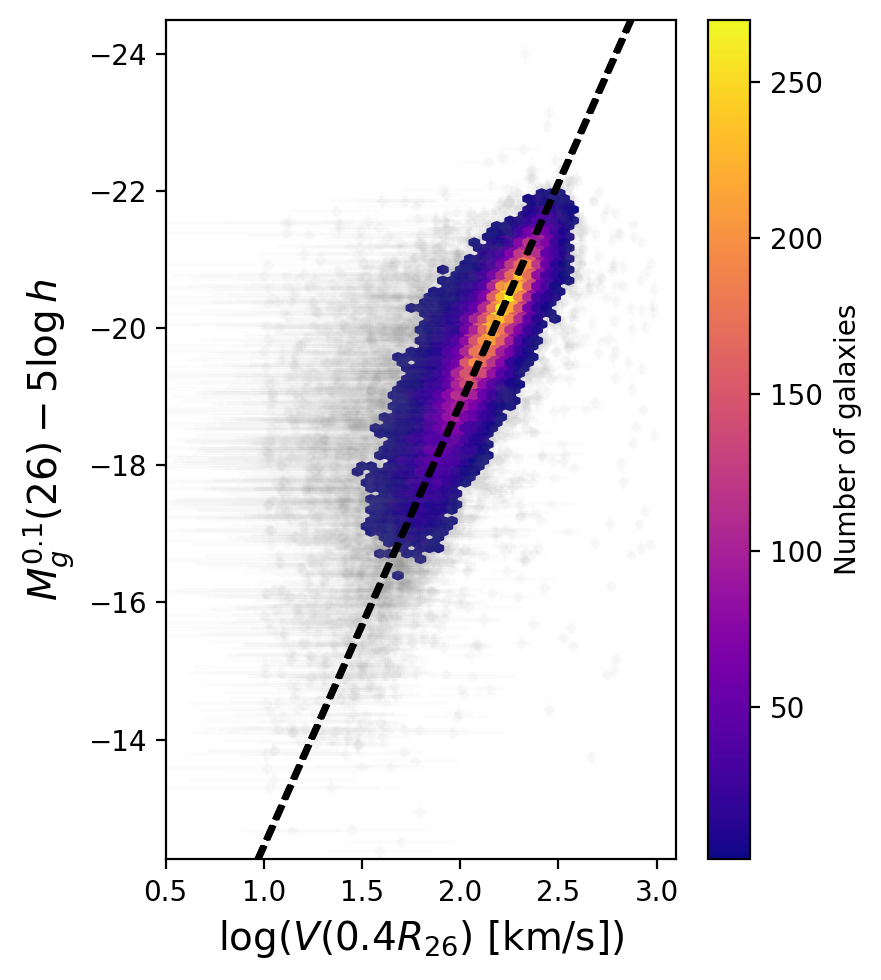

In [56]:
plt.figure(figsize=(4.5,5), tight_layout=True, dpi=200)

sample = outlier_boolean# & morph_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['G_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['G_ABSMAG_SB26_ERR'][sample], 
             fmt='.',
             color='gray',
             alpha=0.02, 
             ecolor='gray')

sample = ~outlier_boolean 
plt.hexbin(np.log10(SGA_TF['V_0p4R26'][sample]), 
           SGA_TF['G_ABSMAG_SB26'][sample], 
           cmap='plasma', 
           mincnt=1, 
           gridsize=(70,80), 
           extent=(-0.1, 3.1, -25, -12.25))
plt.colorbar(label='Number of galaxies')

# plt.fill_between(logv, line_err[0], line_err[1], color='lightgray', alpha=0.2)
plt.plot(logv, g_absmag, 'k--', zorder=3)

plt.xlim([0.5, 3.1])
plt.ylim([-12.25, -24.5])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_g^{0.1} (26) - 5\log h$', fontsize=14);

In [57]:
# First, match each galaxy to its redshift bin
zbin_indices = np.digitize(SGA_TF['Z_DESI_CMB'], zbins, right=True)

# For those galaxies that fall outside the calibration range, assign them to the closest bin
zbin_indices[zbin_indices == 0] = 1
zbin_indices[zbin_indices == len(zbins)] = len(zbins) - 1

# Then, use that galaxy's redshift bin's zero-point to calculate the distance modulus
SGA_TF['G_ABSMAG_SB26_TF'] = np.nan
for i in range(len(SGA_TF)):
    SGA_TF['G_ABSMAG_SB26_TF'][i] = g_slope*(np.log10(SGA_TF['V_0p4R26'][i]) - logV0) + g_ZP[zbin_indices[i] - 1]

In [58]:
SGA_TF['G_ABSMAG_SB26_TF_ERR'] = np.nan
SGA_TF['G_ABSMAG_SB26_TF_ERR_STAT'] = np.nan

rng = np.random.default_rng()

for i in tqdm(range(len(SGA_TF))):
    
    v_random = rng.normal(SGA_TF['V_0p4R26'][i], 
                          SGA_TF['V_0p4R26_ERR'][i], 
                          size=10000
                          # size=len(slopes)
                         )
    # logv_random = rng.normal(np.log10(SGA_TF['V_0p4R26'][i]), 
    #                          0.434*SGA_TF['V_0p4R26_ERR'][i]/SGA_TF['V_0p4R26'][i], 
    #                          size=len(slopes))

    ############################################################################
    # Statistical uncertainty
    #---------------------------------------------------------------------------
    Ms_stat = g_slope*(np.log10(v_random[v_random > 0]) - logV0) + g_ZP[zbin_indices[i] - 1]
    # Ms_stat = slope*(logv_random - V0) + ZP

    SGA_TF['G_ABSMAG_SB26_TF_ERR_STAT'][i] = np.nanstd(Ms_stat)
    ############################################################################

    
    ############################################################################
    # Total uncertainty
    #
    # THIS NEEDS TO BE UPDATED TO INCLUDE THE SLOPE & Y-INTERCEPT UNCERTAINTIES
    #---------------------------------------------------------------------------
    # Ms = slopes[v_random > 0]*(np.log10(v_random[v_random > 0]) - V0) + ZPs[v_random > 0]
    # Ms = slopes*(logv_random - V0) + ZPs
    
    # SGA_TF['R_ABSMAG_SB26_TF_ERR'][i] = np.nanstd(Ms)
    SGA_TF['G_ABSMAG_SB26_TF_ERR'][i] = np.sqrt(SGA_TF['G_ABSMAG_SB26_TF_ERR_STAT'][i]**2 + g_sig**2)
    ############################################################################
    

################################################################################
# Systematic uncertainty
#-------------------------------------------------------------------------------
SGA_TF['G_ABSMAG_SB26_TF_ERR_SYS'] = np.sqrt(SGA_TF['G_ABSMAG_SB26_TF_ERR']**2 - SGA_TF['G_ABSMAG_SB26_TF_ERR_STAT']**2)
################################################################################

100%|██████████| 35607/35607 [00:13<00:00, 2619.21it/s]


In [59]:
SGA_TF['G_MU_TF'] = SGA_TF['G_MAG_SB26_CORR'] - SGA_TF['G_ABSMAG_SB26_TF']

SGA_TF['G_MU_TF_ERR'] = np.sqrt(SGA_TF['G_MAG_SB26_ERR_CORR']**2 + SGA_TF['G_ABSMAG_SB26_TF_ERR']**2)

## $\eta$ v. redshift

In [60]:
SGA_TF['G_LOGDIST'] = 0.2*(SGA_TF['MU_ZCMB'] - SGA_TF['G_MU_TF'])
SGA_TF['G_LOGDIST_ERR'] = 0.2*np.sqrt(SGA_TF['MU_ZCMB_ERR']**2 + SGA_TF['G_MU_TF_ERR']**2)

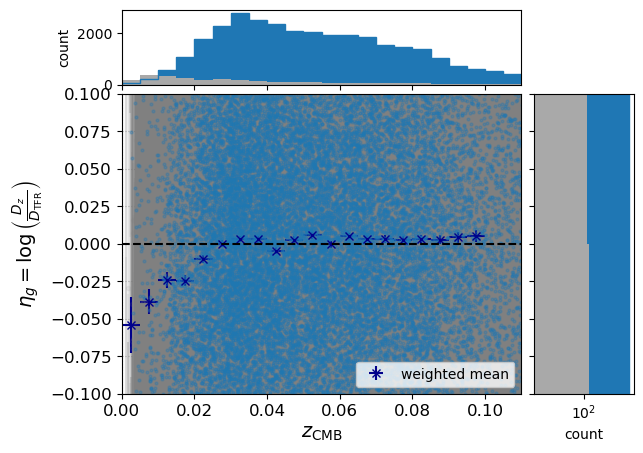

In [61]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~outlier_boolean
sample2 = outlier_boolean

fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])

ax.errorbar(SGA_TF['Z_DESI_CMB'][sample2], 
             SGA_TF['G_LOGDIST'][sample2], 
             xerr=SGA_TF['ZERR_DESI'][sample2], 
             yerr=SGA_TF['G_LOGDIST_ERR'][sample2],
             fmt='.', 
             color='gray',
             alpha=0.1, 
             ecolor='gray')

ax.errorbar(SGA_TF['Z_DESI_CMB'][sample1], 
             SGA_TF['G_LOGDIST'][sample1], 
             xerr=SGA_TF['ZERR_DESI'][sample1], 
             yerr=SGA_TF['G_LOGDIST_ERR'][sample1],
             fmt='.', 
             markersize=4, 
             alpha=0.3, 
             ecolor='gray')

# Plot the weighted mean
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['G_LOGDIST'][sample1], 
                                    zbins, 
                                    weights=SGA_TF['G_LOGDIST_ERR'][sample1]**-2, 
                                    weighted=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='weighted mean')
'''
# Plot the median
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['G_LOGDIST'][sample1], 
                                    zbins, 
                                    median=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='lightsteelblue', label='median')
'''
# Line at eta = 0
ax.hlines(0, 0, 0.2, linestyles='dashed', colors='k', zorder=5)

ax.legend()

ax.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=14)
ax.set_ylabel(r'$\eta_g = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$', fontsize=14)

# ax.set_ylim((-1.9, 1.9))
ax.set_xlim((0, 0.2))
# ax.set_ylim((-0.5, 0.5))
ax.set_ylim((-0.1, 0.1))
ax.set_xlim((0, 0.11))

ax.grid(ls=':')


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(SGA_TF['Z_DESI_CMB'][sample1], 
              bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(SGA_TF['Z_DESI_CMB'][sample2], 
              bins=np.arange(0, 0.175, 0.005), 
              color='darkgray')
ax_histx.hist(SGA_TF['Z_DESI_CMB'][sample1], 
              bins=np.arange(0, 0.175, 0.005), 
              color='tab:blue', 
              histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('count')


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
ax_histy.hist(SGA_TF['G_LOGDIST'][sample1], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal')
ax_histy.hist(SGA_TF['G_LOGDIST'][sample2], 
              bins=np.arange(-2, 2, 0.1), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(SGA_TF['G_LOGDIST'][sample1], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              histtype='step',
              color='tab:blue')

ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.set_xlabel('count');

# plt.savefig('../../Figures/Y1/iron_logdist-v-z_jointTFR-varyV0-perpdwarfs_z0p1_Anthony2_weightsVmax-1_dVsys_20250717.png', 
#             dpi=150, 
#             facecolor='none', 
#             bbox_inches='tight');

# Calculate z-band magnitude

In [62]:
temp_infile = open('/pscratch/sd/s/sgmoore1/TF/pickles/Y3/cov_ab_jura_jointTFR_HDBSCAN_z_v1.pickle', 
                   'rb')
z_cov_ab, z_tfr_samples, logV0, zmin, zmax, dz, zbins = pickle.load(temp_infile)
temp_infile.close()

In [63]:
z_slope = np.median(z_tfr_samples[0])
z_slope_err = np.sqrt(z_cov_ab[0,0])

# Each redshift bin has its own 0pt
# To put it in absolute-magnitude space, we'll convert it to an absolute magnitude using the middle of the redshift bin
z_ZP = np.median(z_tfr_samples[1:-1], axis=1) - mu_zc.value
z_ZP_err = np.sqrt(np.diagonal(z_cov_ab[1:-1,1:-1])) # Should include z-bin width to this uncertainty

z_sig = np.median(z_tfr_samples[-1])

logv = np.linspace(-1*np.ones(len(zbins)-1), 3.5*np.ones(len(zbins)-1), 100)
z_absmag = z_slope*(logv - logV0) + z_ZP

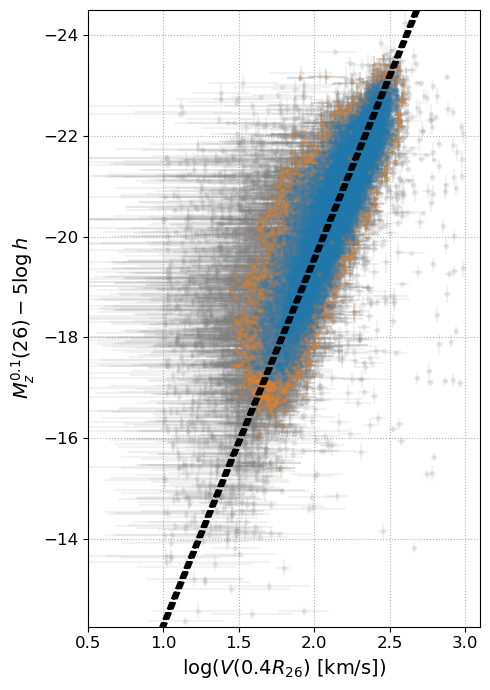

In [64]:
plt.figure(figsize=(5,7), tight_layout=True)

plt.grid(ls=':')

# plt.fill_between(logv, line_err[0], line_err[1], color='lightgray')

sample = outlier_boolean# & morph_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['Z_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['Z_ABSMAG_SB26_ERR'][sample], 
             fmt='.',
             color='gray',
             alpha=0.1, 
             ecolor='gray')

sample = ~outlier_boolean# & morph_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['Z_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['Z_ABSMAG_SB26_ERR'][sample], 
             fmt='.', 
             markersize=4, 
             alpha=0.1, 
             ecolor='gray')

sample = ~outlier_boolean_alt & outlier_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['Z_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['Z_ABSMAG_SB26_ERR'][sample], 
             fmt='.', 
             markersize=4, 
             alpha=0.2, 
             ecolor='gray')

plt.plot(logv, z_absmag, 'k--', zorder=3)

plt.xlim([0.5, 3.1])
plt.ylim([-12.25, -24.5])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_z^{0.1} (26) - 5\log h$', fontsize=14);

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../Figures/Y1/iron_jointTFR_varyV0-perpdwarf_z0p1_Anthony2_weightsVmax-1_dVsys_20250717.png', 
#             dpi=150, 
#             facecolor='none')

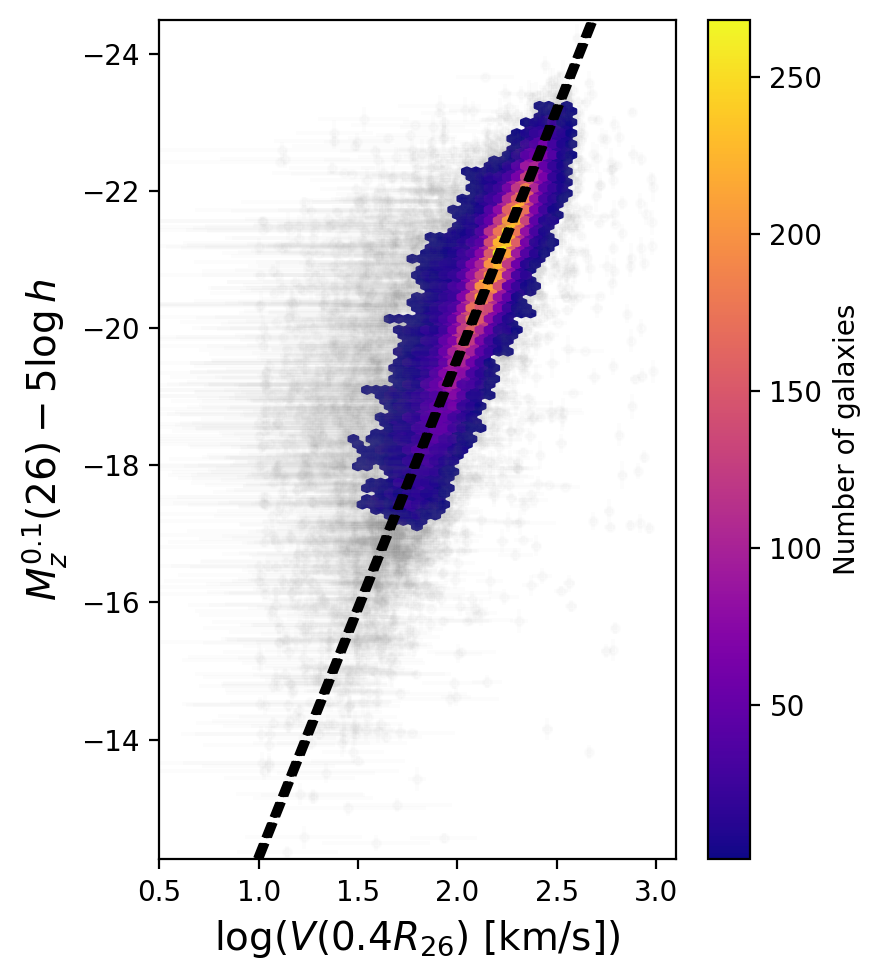

In [65]:
plt.figure(figsize=(4.5,5), tight_layout=True, dpi=200)

sample = outlier_boolean# & morph_boolean
plt.errorbar(np.log10(SGA_TF['V_0p4R26'][sample]), 
             SGA_TF['Z_ABSMAG_SB26'][sample], 
             xerr=0.434*SGA_TF['V_0p4R26_ERR'][sample]/SGA_TF['V_0p4R26'][sample],
             yerr=SGA_TF['Z_ABSMAG_SB26_ERR'][sample], 
             fmt='.',
             color='gray',
             alpha=0.02, 
             ecolor='gray')

sample = ~outlier_boolean 
plt.hexbin(np.log10(SGA_TF['V_0p4R26'][sample]), 
           SGA_TF['Z_ABSMAG_SB26'][sample], 
           cmap='plasma', 
           mincnt=1, 
           gridsize=(70,80), 
           extent=(-0.1, 3.1, -25, -12.25))
plt.colorbar(label='Number of galaxies')

# plt.fill_between(logv, line_err[0], line_err[1], color='lightgray', alpha=0.2)
plt.plot(logv, z_absmag, 'k--', zorder=3)

plt.xlim([0.5, 3.1])
plt.ylim([-12.25, -24.5])

plt.xlabel('log($V(0.4R_{26})$ [km/s])', fontsize=14)
plt.ylabel('$M_z^{0.1} (26) - 5\log h$', fontsize=14);

In [66]:
# First, match each galaxy to its redshift bin
zbin_indices = np.digitize(SGA_TF['Z_DESI_CMB'], zbins, right=True)

# For those galaxies that fall outside the calibration range, assign them to the closest bin
zbin_indices[zbin_indices == 0] = 1
zbin_indices[zbin_indices == len(zbins)] = len(zbins) - 1

# Then, use that galaxy's redshift bin's zero-point to calculate the distance modulus
SGA_TF['Z_ABSMAG_SB26_TF'] = np.nan
for i in range(len(SGA_TF)):
    SGA_TF['Z_ABSMAG_SB26_TF'][i] = z_slope*(np.log10(SGA_TF['V_0p4R26'][i]) - logV0) + z_ZP[zbin_indices[i] - 1]

In [67]:
SGA_TF['Z_ABSMAG_SB26_TF_ERR'] = np.nan
SGA_TF['Z_ABSMAG_SB26_TF_ERR_STAT'] = np.nan

rng = np.random.default_rng()

for i in tqdm(range(len(SGA_TF))):
    
    v_random = rng.normal(SGA_TF['V_0p4R26'][i], 
                          SGA_TF['V_0p4R26_ERR'][i], 
                          size=10000
                          # size=len(slopes)
                         )
    # logv_random = rng.normal(np.log10(SGA_TF['V_0p4R26'][i]), 
    #                          0.434*SGA_TF['V_0p4R26_ERR'][i]/SGA_TF['V_0p4R26'][i], 
    #                          size=len(slopes))

    ############################################################################
    # Statistical uncertainty
    #---------------------------------------------------------------------------
    Ms_stat = z_slope*(np.log10(v_random[v_random > 0]) - logV0) + z_ZP[zbin_indices[i] - 1]
    # Ms_stat = slope*(logv_random - V0) + ZP

    SGA_TF['Z_ABSMAG_SB26_TF_ERR_STAT'][i] = np.nanstd(Ms_stat)
    ############################################################################

    
    ############################################################################
    # Total uncertainty
    #
    # THIS NEEDS TO BE UPDATED TO INCLUDE THE SLOPE & Y-INTERCEPT UNCERTAINTIES
    #---------------------------------------------------------------------------
    # Ms = slopes[v_random > 0]*(np.log10(v_random[v_random > 0]) - V0) + ZPs[v_random > 0]
    # Ms = slopes*(logv_random - V0) + ZPs
    
    # SGA_TF['R_ABSMAG_SB26_TF_ERR'][i] = np.nanstd(Ms)
    SGA_TF['Z_ABSMAG_SB26_TF_ERR'][i] = np.sqrt(SGA_TF['Z_ABSMAG_SB26_TF_ERR_STAT'][i]**2 + z_sig**2)
    ############################################################################
    

################################################################################
# Systematic uncertainty
#-------------------------------------------------------------------------------
SGA_TF['Z_ABSMAG_SB26_TF_ERR_SYS'] = np.sqrt(SGA_TF['Z_ABSMAG_SB26_TF_ERR']**2 - SGA_TF['Z_ABSMAG_SB26_TF_ERR_STAT']**2)
################################################################################

100%|██████████| 35607/35607 [00:13<00:00, 2617.24it/s]


In [68]:
SGA_TF['Z_MU_TF'] = SGA_TF['Z_MAG_SB26_CORR'] - SGA_TF['Z_ABSMAG_SB26_TF']

SGA_TF['Z_MU_TF_ERR'] = np.sqrt(SGA_TF['Z_MAG_SB26_ERR_CORR']**2 + SGA_TF['Z_ABSMAG_SB26_TF_ERR']**2)

## $\eta$ v. redshift

In [69]:
SGA_TF['Z_LOGDIST'] = 0.2*(SGA_TF['MU_ZCMB'] - SGA_TF['Z_MU_TF'])
SGA_TF['Z_LOGDIST_ERR'] = 0.2*np.sqrt(SGA_TF['MU_ZCMB_ERR']**2 + SGA_TF['Z_MU_TF_ERR']**2)

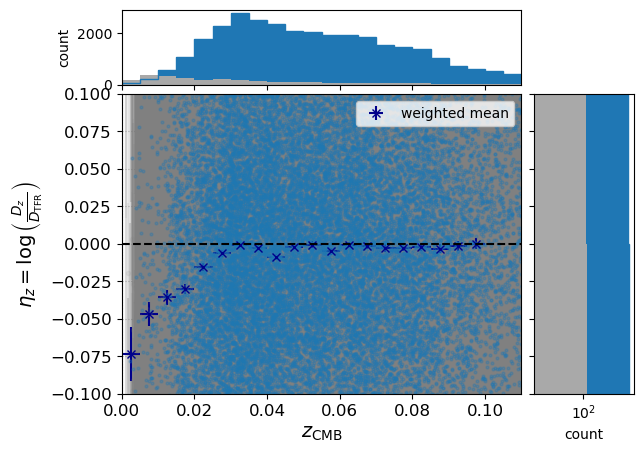

In [70]:
zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

sample1 = ~outlier_boolean
sample2 = outlier_boolean

fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])

ax.errorbar(SGA_TF['Z_DESI_CMB'][sample2], 
             SGA_TF['Z_LOGDIST'][sample2], 
             xerr=SGA_TF['ZERR_DESI'][sample2], 
             yerr=SGA_TF['Z_LOGDIST_ERR'][sample2],
             fmt='.', 
             color='gray',
             alpha=0.1, 
             ecolor='gray')

ax.errorbar(SGA_TF['Z_DESI_CMB'][sample1], 
             SGA_TF['Z_LOGDIST'][sample1], 
             xerr=SGA_TF['ZERR_DESI'][sample1], 
             yerr=SGA_TF['Z_LOGDIST_ERR'][sample1],
             fmt='.', 
             markersize=4, 
             alpha=0.3, 
             ecolor='gray')

# Plot the weighted mean
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['Z_LOGDIST'][sample1], 
                                    zbins, 
                                    weights=SGA_TF['Z_LOGDIST_ERR'][sample1]**-2, 
                                    weighted=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='weighted mean')
'''
# Plot the median
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['Z_LOGDIST'][sample1], 
                                    zbins, 
                                    median=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='lightsteelblue', label='median')
'''
# Line at eta = 0
ax.hlines(0, 0, 0.2, linestyles='dashed', colors='k', zorder=5)

ax.legend()

ax.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=14)
ax.set_ylabel(r'$\eta_z = \log \left( \frac{D_z}{D_{\text{TFR}}} \right)$', fontsize=14)

# ax.set_ylim((-1.9, 1.9))
ax.set_xlim((0, 0.2))
# ax.set_ylim((-0.5, 0.5))
ax.set_ylim((-0.1, 0.1))
ax.set_xlim((0, 0.11))

ax.grid(ls=':')


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(SGA_TF['Z_DESI_CMB'][sample1], 
              bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(SGA_TF['Z_DESI_CMB'][sample2], 
              bins=np.arange(0, 0.175, 0.005), 
              color='darkgray')
ax_histx.hist(SGA_TF['Z_DESI_CMB'][sample1], 
              bins=np.arange(0, 0.175, 0.005), 
              color='tab:blue', 
              histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.set_ylabel('count')


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
ax_histy.hist(SGA_TF['Z_LOGDIST'][sample1], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal')
ax_histy.hist(SGA_TF['Z_LOGDIST'][sample2], 
              bins=np.arange(-2, 2, 0.1), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(SGA_TF['Z_LOGDIST'][sample1], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              histtype='step',
              color='tab:blue')

ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.set_xlabel('count');

# plt.savefig('../../Figures/Y1/iron_logdist-v-z_jointTFR-varyV0-perpdwarfs_z0p1_Anthony2_weightsVmax-1_dVsys_20250717.png', 
#             dpi=150, 
#             facecolor='none', 
#             bbox_inches='tight');

# Look at average distance moduli

In [71]:
SGA_TF['MU_TF_AVG'] = (SGA_TF['R_MU_TF'] + SGA_TF['G_MU_TF'] + SGA_TF['Z_MU_TF'])/3

SGA_TF['MU_TF_AVG_ERR'] = np.sqrt(SGA_TF['R_MU_TF_ERR']**2 + SGA_TF['G_MU_TF_ERR']**2 + SGA_TF['Z_MU_TF_ERR']**2)/3

SGA_TF['LOGDIST_AVG'] = 0.2*(SGA_TF['MU_ZCMB'] - SGA_TF['MU_TF_AVG'])
SGA_TF['LOGDIST_AVG_ERR'] = 0.2*np.sqrt(SGA_TF['MU_ZCMB_ERR']**2 + SGA_TF['MU_TF_AVG_ERR']**2)

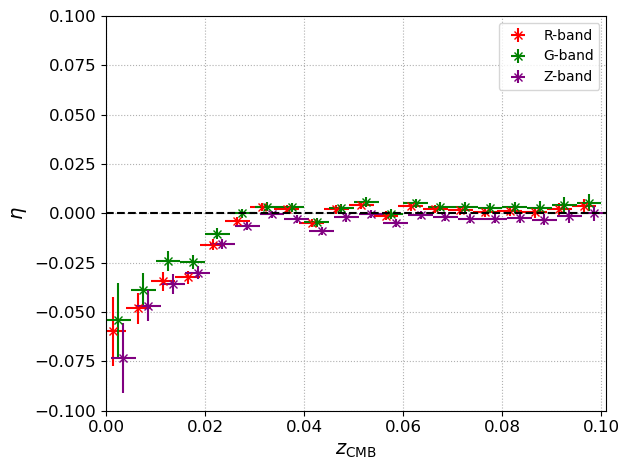

In [72]:
_zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(_zbins)
zc = 0.5*(_zbins[1:] + _zbins[:-1])

sample1 = ~outlier_boolean


plt.figure(tight_layout=True)

# plt.plot(tf_data['Z_DESI_CMB'][sample1], tf_data['R_ABSMAG_SB26_TF_ERR'][sample1], '.', alpha=0.1)

# R-band
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['R_LOGDIST'][sample1], 
                                    _zbins, 
                                    weights=SGA_TF['R_LOGDIST_ERR'][sample1]**-2, 
                                    weighted=True)
plt.errorbar(zc-0.001, y_avg, xerr=dz, yerr=y_std, fmt='x', color='red', label='R-band')

# G-band
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['G_LOGDIST'][sample1], 
                                    _zbins, 
                                    weights=SGA_TF['G_LOGDIST_ERR'][sample1]**-2, 
                                    weighted=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='green', label='G-band')

# Z-band
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['Z_LOGDIST'][sample1], 
                                    _zbins, 
                                    weights=SGA_TF['Z_LOGDIST_ERR'][sample1]**-2, 
                                    weighted=True)
plt.errorbar(zc+0.001, y_avg, xerr=dz, yerr=y_std, fmt='x', color='purple', label='Z-band')


#### Average
# N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
#                                     SGA_TF['LOGDIST_AVG'][sample1], 
#                                     _zbins, 
#                                     weights=SGA_TF['LOGDIST_AVG_ERR'][sample1]**-2, 
#                                     weighted=True)
# plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='lightsteelblue', label='Average')


plt.hlines(0, 0, 0.11, linestyles='dashed', colors='k', zorder=5)
plt.grid(ls=':')

plt.legend()

plt.xlim(0, 0.101)
plt.ylim(-0.1,0.1)

plt.tick_params(axis='both', which='major', labelsize=12)

plt.xlabel(r'$z_{\text{CMB}}$', fontsize=14)
plt.ylabel(r'$\eta$', fontsize=14);

In [73]:
LightSpeed = 299792.458
zmin = 0.01        # minimum redshift for selection
zmax = 0.1         # maximum redshift for selection
ngrid = 128        # grid size for number density
nzbin = 36         # number of redshift bins for plotting
rsets = 18         # number of DESI random catalogues to use
survey_area = 7739.58 * (np.pi/180.0)**2
cosmo = FlatLambdaCDM(H0=100.0,Om0=0.3151)
deccel = 3.0*0.3151/2.0 - 1.0

In [74]:
SGA_TF[:5]

<Table length=5>
 SGA_ID  SGA_GALAXY ...       LOGDIST_AVG         LOGDIST_AVG_ERR   
                    ...           mag                   mag         
float64   bytes16   ...         float64               float64       
------- ----------- ... ----------------------- --------------------
   20.0 SGA-2020 20 ...     0.00752023036232572  0.05902845054488039
   32.0 SGA-2020 32 ...     0.02139496970731756  0.05538153962447363
   38.0 SGA-2020 38 ...     0.05283716558061116  0.05918712780574478
   53.0 SGA-2020 53 ...    -0.14695814161284632 0.052331245118753325
   55.0 SGA-2020 55 ... -0.00010547109075815798 0.062335587273496675

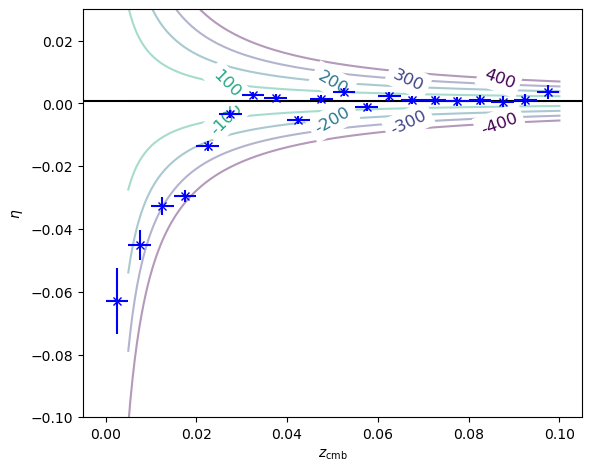

In [75]:
###### Make a plot with the PV lines on it:
combined_cat = SGA_TF.to_pandas()
fit_cat = combined_cat.drop(combined_cat[combined_cat["Z_DESI_CMB"] < 0.023].index)
fit, fit_cov = np.polyfit(fit_cat["Z_DESI_CMB"].to_numpy(), fit_cat["LOGDIST_AVG"].to_numpy(), deg=0, w=1.0/fit_cat["LOGDIST_AVG_ERR"].to_numpy(), cov='unscaled')

# print(fit[0], 10.0**fit[0], np.sqrt(fit_cov)[0,0], fit_TF[0], 10.0**fit_TF[0], np.sqrt(fit_TF_cov)[0,0], fit_FP[0], 10.0**fit_FP[0], np.sqrt(fit_FP_cov)[0,0])

sample1 = ~outlier_boolean
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['LOGDIST_AVG'][sample1], 
                                    _zbins, 
                                    weights=SGA_TF['LOGDIST_AVG_ERR'][sample1]**-2, 
                                    weighted=True)


velarray = np.array([-400.0, -300.0, -200.0, -100.0, 0.0, 100.0, 200.0, 300.0, 400.0])
zarray = np.linspace(0.005, 0.1, 200)
dzarray = cosmo.comoving_distance(zarray).value
dharray = cosmo.comoving_distance(np.outer(1.0/(1.0 + velarray/LightSpeed), (1.0 + zarray)) - 1.0).value
deltamarray = np.log10(dzarray/dharray)
colors = 0.8*np.fabs(velarray)/np.amax(np.fabs(velarray)) + 0.2

rotation = [20.0, 25.0, 30.0, 45.0, 0.0, -45.0, -30.0, -25.0, -20.0]
labels = ["-400", "-300", "-200", "-100", "0", "100", "200", "300", "400"]
xcoord = np.array([26000.0, 20000.0, 15000.0, 8000.0, -1000.0, 8000.0, 15000.0, 20000.0, 26000.0])
coord = np.searchsorted(zarray, xcoord/LightSpeed)
ycoord = np.array([deltamarray[i,j]+fit[0] for i, j in enumerate(coord)]) 

#plt.plot(combined_cat["ZCMB"], combined_cat["DELTA_M"], marker='o', color='r', ms=4, ls='None', alpha=0.01)
fig = plt.figure()
ax=fig.add_axes([0.19,0.13,0.78,0.85])
# ax.errorbar((bins[1:]+bins[:-1])/2.0, data_mean, yerr=data_mean_err, ls='None', mfc='k', mec='k', marker='s', color='k', ms=4, zorder=3, label="Combined")
# ax.errorbar((bins[1:]+bins[:-1])/2.0, FP_mean, yerr=FP_mean_err, ls='None', mfc='r', mec='k', marker='s', color='r', ms=4, zorder=3, label="FP")
# ax.errorbar((bins[1:]+bins[:-1])/2.0, TF_mean, yerr=TF_mean_err, ls='None', mfc='b', mec='k', marker='s', color='b', ms=4, zorder=3, label="TF")
ax.axhline(y=fit[0], color='k', ls='-', zorder=2)
for v in range(len(velarray)):
    ax.plot(zarray, deltamarray[v,:]+fit[0], color=plt.cm.viridis_r(colors[v]), linestyle='-', alpha=0.4, zorder=0)
    if (v != 4):
        ax.text(xcoord[v]/LightSpeed, ycoord[v], labels[v], color=plt.cm.viridis_r(colors[v]), fontsize=12, rotation=rotation[v], ha="center", va="center", bbox=dict(boxstyle="square", ec="w", fc="w"), zorder=1)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='blue', label='R-band')
ax.set_ylim(-0.1, 0.03)
ax.set_xlabel(r"$z_\mathrm{cmb}$")
ax.set_ylabel(r"$\eta$")
plt.show()

In [94]:
_zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(_zbins)
zc = 0.5*(_zbins[1:] + _zbins[:-1])

sample1 = ~outlier_boolean

/tmp/ipykernel_1624633/2497047337.py:20: RuntimeWarning: invalid value encountered in log10
  deltamarray = np.log10(dzarray/dharray)


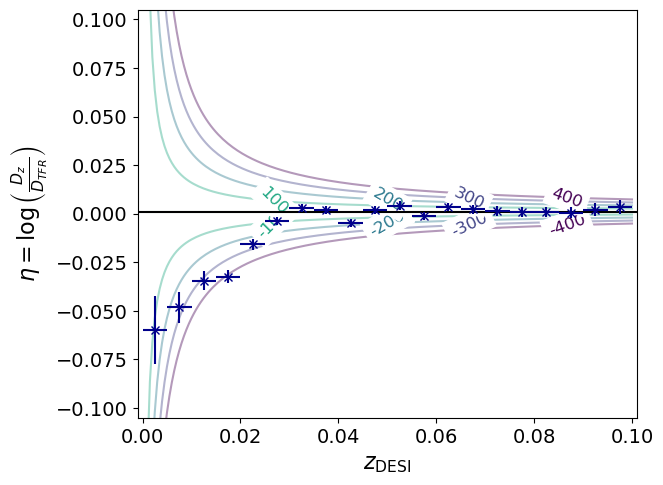

In [74]:
###### Make a plot with the PV lines on it:
combined_cat = SGA_TF.to_pandas()
fit_cat = combined_cat.drop(combined_cat[combined_cat["Z_DESI_CMB"] < 0.023].index)
fit, fit_cov = np.polyfit(fit_cat["Z_DESI_CMB"].to_numpy(), fit_cat["R_LOGDIST"].to_numpy(), deg=0, w=1.0/fit_cat["R_LOGDIST_ERR"].to_numpy(), cov='unscaled')

# print(fit[0], 10.0**fit[0], np.sqrt(fit_cov)[0,0], fit_TF[0], 10.0**fit_TF[0], np.sqrt(fit_TF_cov)[0,0], fit_FP[0], 10.0**fit_FP[0], np.sqrt(fit_FP_cov)[0,0])

sample1 = ~outlier_boolean
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample1], 
                                    SGA_TF['R_LOGDIST'][sample1], 
                                    _zbins, 
                                    weights=SGA_TF['R_LOGDIST_ERR'][sample1]**-2, 
                                    weighted=True)


velarray = np.array([-400.0, -300.0, -200.0, -100.0, 0.0, 100.0, 200.0, 300.0, 400.0])
zarray = np.linspace(0.001, 0.1, 200)
dzarray = cosmo.comoving_distance(zarray).value
dharray = cosmo.comoving_distance(np.outer(1.0/(1.0 + velarray/LightSpeed), (1.0 + zarray)) - 1.0).value
deltamarray = np.log10(dzarray/dharray)
colors = 0.8*np.fabs(velarray)/np.amax(np.fabs(velarray)) + 0.2

rotation = [20.0, 25.0, 30.0, 45.0, 0.0, -45.0, -30.0, -25.0, -20.0]
labels = ["-400", "-300", "-200", "-100", "0", "100", "200", "300", "400"]
xcoord = np.array([26000.0, 20000.0, 15000.0, 8000.0, -1000.0, 8000.0, 15000.0, 20000.0, 26000.0])
coord = np.searchsorted(zarray, xcoord/LightSpeed)
ycoord = np.array([deltamarray[i,j]+fit[0] for i, j in enumerate(coord)]) 

#plt.plot(combined_cat["ZCMB"], combined_cat["DELTA_M"], marker='o', color='r', ms=4, ls='None', alpha=0.01)
fig = plt.figure()
ax=fig.add_axes([0.19,0.13,0.78,0.85])
# ax.errorbar((bins[1:]+bins[:-1])/2.0, data_mean, yerr=data_mean_err, ls='None', mfc='k', mec='k', marker='s', color='k', ms=4, zorder=3, label="Combined")
# ax.errorbar((bins[1:]+bins[:-1])/2.0, FP_mean, yerr=FP_mean_err, ls='None', mfc='r', mec='k', marker='s', color='r', ms=4, zorder=3, label="FP")
# ax.errorbar((bins[1:]+bins[:-1])/2.0, TF_mean, yerr=TF_mean_err, ls='None', mfc='b', mec='k', marker='s', color='b', ms=4, zorder=3, label="TF")
ax.axhline(y=fit[0], color='k', ls='-', zorder=2)
for v in range(len(velarray)):
    ax.plot(zarray, deltamarray[v,:]+fit[0], color=plt.cm.viridis_r(colors[v]), linestyle='-', alpha=0.4, zorder=0)
    if (v != 4):
        ax.text(xcoord[v]/LightSpeed, ycoord[v], labels[v], color=plt.cm.viridis_r(colors[v]), fontsize=12, rotation=rotation[v], ha="center", va="center", bbox=dict(boxstyle="square", ec="w", fc="w"), zorder=1)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='r-band')
ax.set_ylim(-0.105, 0.105)
ax.set_xlim(-0.001,0.101)
ax.set_xlabel(r"$z_\mathrm{DESI}$", fontsize=16)
ax.set_ylabel(r"$\eta = \log\left(\frac{D_{z}}{D_{TFR}}\right)$", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplots_adjust(left=0.22)
plt.savefig('/pscratch/sd/s/sgmoore1/TF/figures/eta_vs_z_pvlines_Y3_HDBSCAN_R.png',
            dpi=150, 
            facecolor='none',
            bbox_inches='tight');

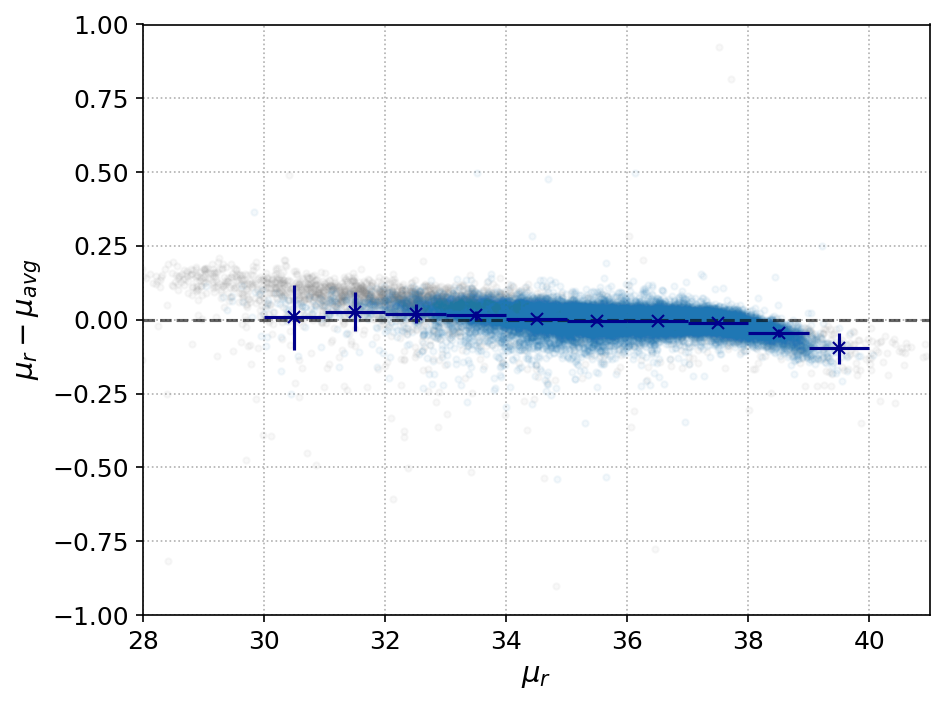

In [75]:
plt.figure(dpi=150,tight_layout=True) # figsize was (5,7)

plt.grid(ls=':')

# plt.fill_between(logv, line_err[0], line_err[1], color='lightgray')

sample = outlier_boolean
plt.errorbar(SGA_TF['R_MU_TF'][sample], 
             SGA_TF['R_MU_TF'][sample] - SGA_TF['MU_TF_AVG'][sample],
             # xerr=SGA_TF['R_MU_TF_ERR'][sample],
             # yerr=np.sqrt(SGA_TF['R_MU_TF_ERR'][sample]**2 + SGA_TF['MU_TF_AVG_ERR'][sample]**2), 
             fmt='.',
             color='gray',
             alpha=0.05, 
             ecolor='gray')


# N, y_avg, y_std = profile_histogram(SGA_TF['R_MU_TF'][sample], 
#                                     SGA_TF['R_MU_TF'][sample] - SGA_TF['MU_TF_AVG'][sample], 
#                                     bins, 
#                                     weights=np.sqrt(SGA_TF['R_MU_TF_ERR'][sample]**2 + SGA_TF['MU_TF_AVG_ERR'][sample]**2)**-2, 
#                                     weighted=True)
# plt.errorbar(bin_c, y_avg, xerr=dbins, yerr=y_std, fmt='x', color='gold', zorder=4)


sample = ~outlier_boolean
plt.errorbar(SGA_TF['R_MU_TF'][sample], 
             SGA_TF['R_MU_TF'][sample] - SGA_TF['MU_TF_AVG'][sample],
             # xerr=SGA_TF['R_MU_TF_ERR'][sample],
             # yerr=np.sqrt(SGA_TF['R_MU_TF_ERR'][sample]**2 + SGA_TF['MU_TF_AVG_ERR'][sample]**2), 
             fmt='.',
             alpha=0.05, 
             ecolor='gray')

bins=np.arange(30,40.2,1)
dbins = 0.5*np.diff(bins)
bin_c = 0.5*(bins[1:] + bins[:-1])
N, y_avg, y_std = profile_histogram(SGA_TF['R_MU_TF'][sample], 
                                    SGA_TF['R_MU_TF'][sample] - SGA_TF['MU_TF_AVG'][sample], 
                                    bins, 
                                    weights=np.sqrt(SGA_TF['R_MU_TF_ERR'][sample]**2 + SGA_TF['MU_TF_AVG_ERR'][sample]**2)**-2, 
                                    weighted=True)
plt.errorbar(bin_c, y_avg, xerr=dbins, yerr=y_std, fmt='x', color='darkblue', zorder=5)

plt.hlines(0, 28, 41, linestyles='dashed', colors='k', zorder=4, alpha=0.6)
plt.xlim([28, 41])
plt.ylim([-1, 1])

plt.xlabel(r'$\mu_r$', fontsize=14)
plt.ylabel(r'$\mu_r - \mu_{avg}$', fontsize=14);

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../../figures/Y1_papers/iron_jointTFR_dwarfAlex_dz0p005_weightsVmax-1_20250810.png', 
#             dpi=150, 
#             facecolor='none')

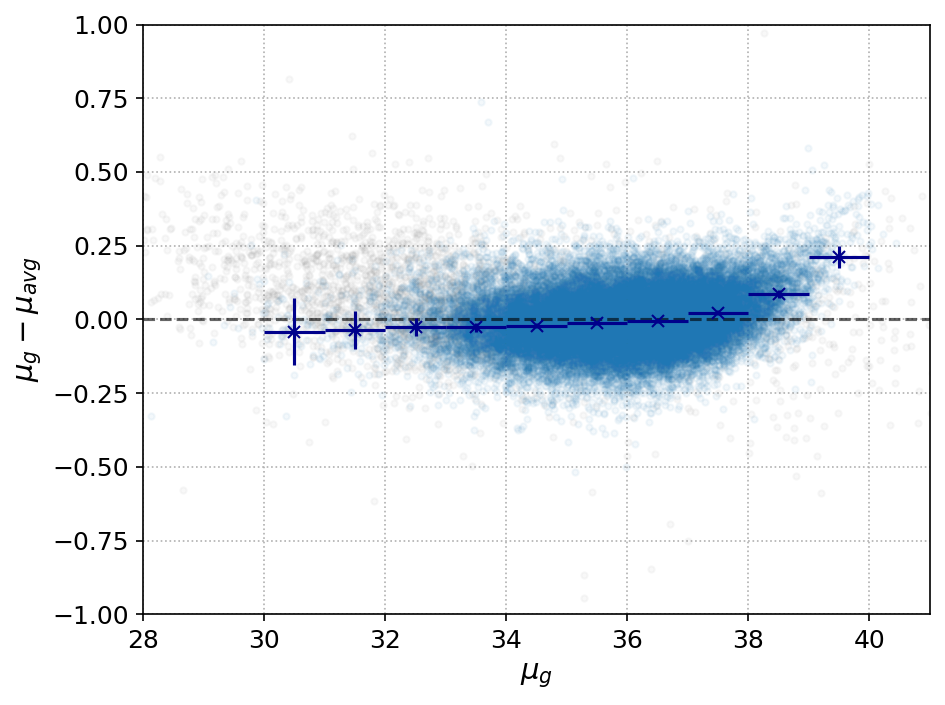

In [76]:
plt.figure(dpi=150,tight_layout=True) # figsize was (5,7)

plt.grid(ls=':')

# plt.fill_between(logv, line_err[0], line_err[1], color='lightgray')

sample = outlier_boolean
plt.errorbar(SGA_TF['G_MU_TF'][sample], 
             SGA_TF['G_MU_TF'][sample] - SGA_TF['MU_TF_AVG'][sample],
             # xerr=SGA_TF['R_MU_TF_ERR'][sample],
             # yerr=np.sqrt(SGA_TF['R_MU_TF_ERR'][sample]**2 + SGA_TF['MU_TF_AVG_ERR'][sample]**2), 
             fmt='.',
             color='gray',
             alpha=0.05, 
             ecolor='gray')


# N, y_avg, y_std = profile_histogram(SGA_TF['R_MU_TF'][sample], 
#                                     SGA_TF['R_MU_TF'][sample] - SGA_TF['MU_TF_AVG'][sample], 
#                                     bins, 
#                                     weights=np.sqrt(SGA_TF['R_MU_TF_ERR'][sample]**2 + SGA_TF['MU_TF_AVG_ERR'][sample]**2)**-2, 
#                                     weighted=True)
# plt.errorbar(bin_c, y_avg, xerr=dbins, yerr=y_std, fmt='x', color='gold', zorder=4)


sample = ~outlier_boolean
plt.errorbar(SGA_TF['G_MU_TF'][sample], 
             SGA_TF['G_MU_TF'][sample] - SGA_TF['MU_TF_AVG'][sample],
             # xerr=SGA_TF['R_MU_TF_ERR'][sample],
             # yerr=np.sqrt(SGA_TF['R_MU_TF_ERR'][sample]**2 + SGA_TF['MU_TF_AVG_ERR'][sample]**2), 
             fmt='.',
             alpha=0.05, 
             ecolor='gray')

bins=np.arange(30,40.2,1)
dbins = 0.5*np.diff(bins)
bin_c = 0.5*(bins[1:] + bins[:-1])
N, y_avg, y_std = profile_histogram(SGA_TF['G_MU_TF'][sample], 
                                    SGA_TF['G_MU_TF'][sample] - SGA_TF['MU_TF_AVG'][sample], 
                                    bins, 
                                    weights=np.sqrt(SGA_TF['G_MU_TF_ERR'][sample]**2 + SGA_TF['MU_TF_AVG_ERR'][sample]**2)**-2, 
                                    weighted=True)
plt.errorbar(bin_c, y_avg, xerr=dbins, yerr=y_std, fmt='x', color='darkblue', zorder=5)

plt.hlines(0, 28, 41, linestyles='dashed', colors='k', zorder=4, alpha=0.6)
plt.xlim([28, 41])
plt.ylim([-1, 1])

plt.xlabel(r'$\mu_g$', fontsize=14)
plt.ylabel(r'$\mu_g - \mu_{avg}$', fontsize=14);

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../../figures/Y1_papers/iron_jointTFR_dwarfAlex_dz0p005_weightsVmax-1_20250810.png', 
#             dpi=150, 
#             facecolor='none')

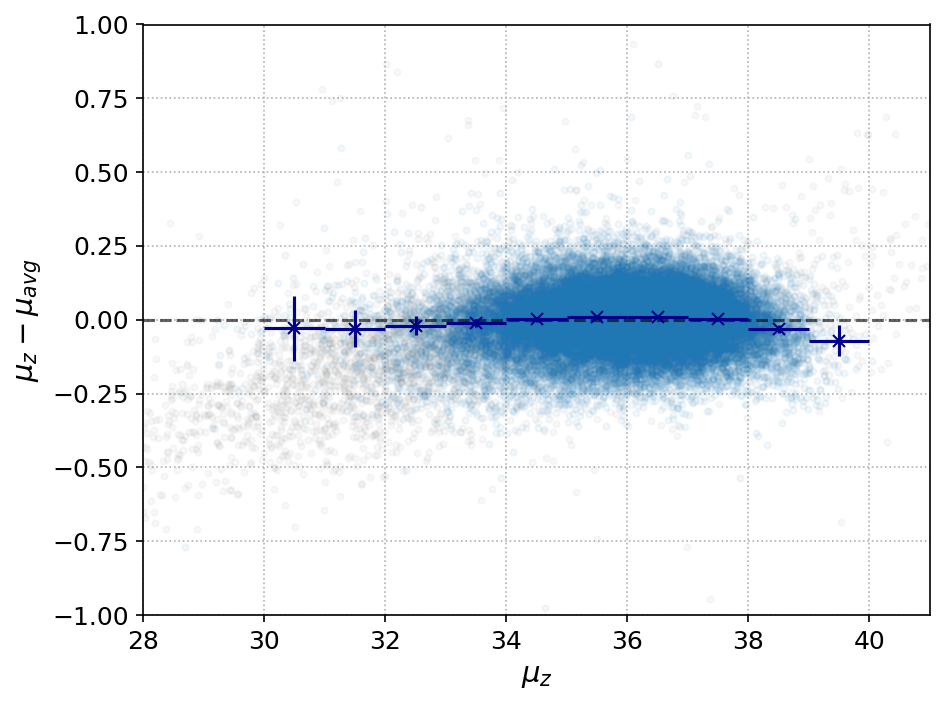

In [77]:
plt.figure(dpi=150,tight_layout=True) # figsize was (5,7)

plt.grid(ls=':')

# plt.fill_between(logv, line_err[0], line_err[1], color='lightgray')

sample = outlier_boolean
plt.errorbar(SGA_TF['Z_MU_TF'][sample], 
             SGA_TF['Z_MU_TF'][sample] - SGA_TF['MU_TF_AVG'][sample],
             # xerr=SGA_TF['R_MU_TF_ERR'][sample],
             # yerr=np.sqrt(SGA_TF['R_MU_TF_ERR'][sample]**2 + SGA_TF['MU_TF_AVG_ERR'][sample]**2), 
             fmt='.',
             color='gray',
             alpha=0.05, 
             ecolor='gray')


# N, y_avg, y_std = profile_histogram(SGA_TF['R_MU_TF'][sample], 
#                                     SGA_TF['R_MU_TF'][sample] - SGA_TF['MU_TF_AVG'][sample], 
#                                     bins, 
#                                     weights=np.sqrt(SGA_TF['R_MU_TF_ERR'][sample]**2 + SGA_TF['MU_TF_AVG_ERR'][sample]**2)**-2, 
#                                     weighted=True)
# plt.errorbar(bin_c, y_avg, xerr=dbins, yerr=y_std, fmt='x', color='gold', zorder=4)


sample = ~outlier_boolean
plt.errorbar(SGA_TF['Z_MU_TF'][sample], 
             SGA_TF['Z_MU_TF'][sample] - SGA_TF['MU_TF_AVG'][sample],
             # xerr=SGA_TF['R_MU_TF_ERR'][sample],
             # yerr=np.sqrt(SGA_TF['R_MU_TF_ERR'][sample]**2 + SGA_TF['MU_TF_AVG_ERR'][sample]**2), 
             fmt='.',
             alpha=0.05, 
             ecolor='gray')

bins=np.arange(30,40.2,1)
dbins = 0.5*np.diff(bins)
bin_c = 0.5*(bins[1:] + bins[:-1])
N, y_avg, y_std = profile_histogram(SGA_TF['Z_MU_TF'][sample], 
                                    SGA_TF['Z_MU_TF'][sample] - SGA_TF['MU_TF_AVG'][sample], 
                                    bins, 
                                    weights=np.sqrt(SGA_TF['Z_MU_TF_ERR'][sample]**2 + SGA_TF['MU_TF_AVG_ERR'][sample]**2)**-2, 
                                    weighted=True)
plt.errorbar(bin_c, y_avg, xerr=dbins, yerr=y_std, fmt='x', color='darkblue', zorder=5)

plt.hlines(0, 28, 41, linestyles='dashed', colors='k', zorder=4, alpha=0.6)
plt.xlim([28, 41])
plt.ylim([-1, 1])

plt.xlabel(r'$\mu_z$', fontsize=14)
plt.ylabel(r'$\mu_z - \mu_{avg}$', fontsize=14);

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../../figures/Y1_papers/iron_jointTFR_dwarfAlex_dz0p005_weightsVmax-1_20250810.png', 
#             dpi=150, 
#             facecolor='none')

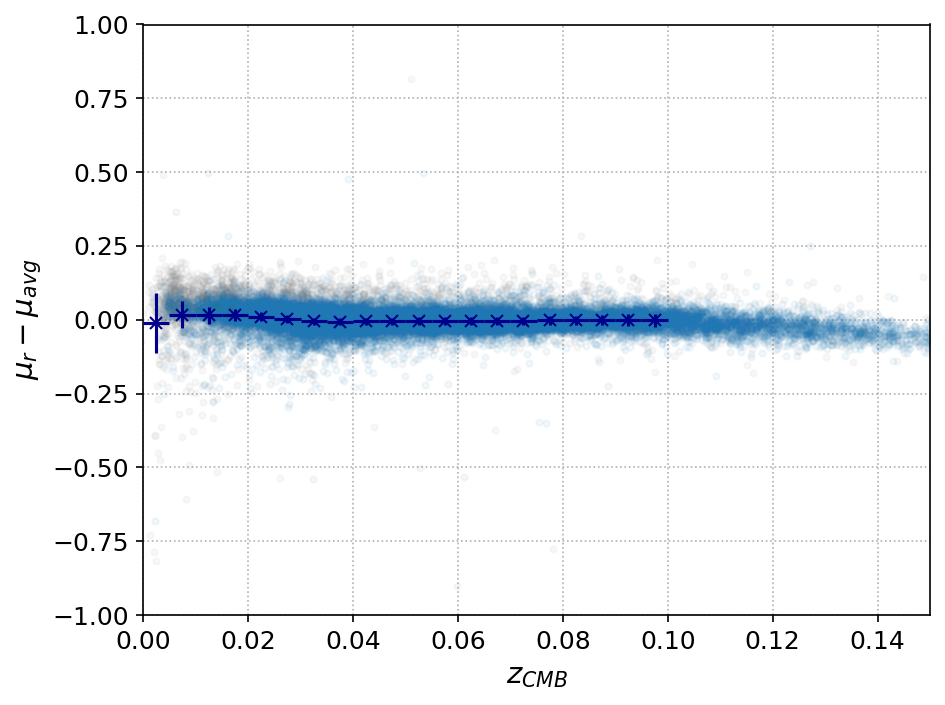

In [78]:
_zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(_zbins)
zc = 0.5*(_zbins[1:] + _zbins[:-1])

plt.figure(dpi=150,tight_layout=True) # figsize was (5,7)

plt.grid(ls=':')

# plt.fill_between(logv, line_err[0], line_err[1], color='lightgray')

sample = outlier_boolean
plt.errorbar(SGA_TF['Z_DESI_CMB'][sample], 
             SGA_TF['R_MU_TF'][sample] - SGA_TF['MU_TF_AVG'][sample],
             # xerr=SGA_TF['R_MU_TF_ERR'][sample],
             # yerr=np.sqrt(SGA_TF['R_MU_TF_ERR'][sample]**2 + SGA_TF['MU_TF_AVG_ERR'][sample]**2), 
             fmt='.',
             color='gray',
             alpha=0.05, 
             ecolor='gray')


# N, y_avg, y_std = profile_histogram(SGA_TF['R_MU_TF'][sample], 
#                                     SGA_TF['R_MU_TF'][sample] - SGA_TF['MU_TF_AVG'][sample], 
#                                     bins, 
#                                     weights=np.sqrt(SGA_TF['R_MU_TF_ERR'][sample]**2 + SGA_TF['MU_TF_AVG_ERR'][sample]**2)**-2, 
#                                     weighted=True)
# plt.errorbar(bin_c, y_avg, xerr=dbins, yerr=y_std, fmt='x', color='gold', zorder=4)


sample = ~outlier_boolean
plt.errorbar(SGA_TF['Z_DESI_CMB'][sample], 
             SGA_TF['R_MU_TF'][sample] - SGA_TF['MU_TF_AVG'][sample],
             # xerr=SGA_TF['R_MU_TF_ERR'][sample],
             # yerr=np.sqrt(SGA_TF['R_MU_TF_ERR'][sample]**2 + SGA_TF['MU_TF_AVG_ERR'][sample]**2), 
             fmt='.',
             alpha=0.05, 
             ecolor='gray')

# bins=np.arange(30,40.2,1)
# dbins = 0.5*np.diff(bins)
# bin_c = 0.5*(bins[1:] + bins[:-1])
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample], 
                                    SGA_TF['R_MU_TF'][sample] - SGA_TF['MU_TF_AVG'][sample], 
                                    _zbins, 
                                    weights=np.sqrt(SGA_TF['R_MU_TF_ERR'][sample]**2 + SGA_TF['MU_TF_AVG_ERR'][sample]**2)**-2, 
                                    weighted=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', zorder=5)

# plt.hlines(0, 28, 41, linestyles='dashed', colors='k', zorder=4, alpha=0.6)
plt.xlim([0, 0.15])
plt.ylim([-1, 1])

plt.xlabel(r'$z_{CMB}$', fontsize=14)
plt.ylabel(r'$\mu_r - \mu_{avg}$', fontsize=14);

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=12);

# plt.savefig('../../../figures/Y1_papers/iron_jointTFR_dwarfAlex_dz0p005_weightsVmax-1_20250810.png', 
#             dpi=150, 
#             facecolor='none')

## Comparison of k-corr vs non k-corr bins

In [ ]:
### For r-band, read in fit and get 

In [186]:
temp_infile = open('/pscratch/sd/s/sgmoore1/TF/pickles/Y3/cov_ab_jura_jointTFR_HDBSCAN_r_band.pickle', 
                   'rb')
rk_cov_ab, rk_tfr_samples, logV0, zmin, zmax, dz, zbins = pickle.load(temp_infile)
temp_infile.close()

In [187]:
zbins = np.arange(0.03, 0.1, 0.005)
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

rk_slope = np.median(rk_tfr_samples[0])
rk_slope_err = np.sqrt(rk_cov_ab[0,0])

# Each redshift bin has its own 0pt
# To put it in absolute-magnitude space, we'll convert it to an absolute magnitude using the middle of the redshift bin
rk_ZP = np.median(rk_tfr_samples[1:-1], axis=1) - mu_zc.value
rk_ZP_err = np.sqrt(np.diagonal(rk_cov_ab[1:-1,1:-1])) # Should include z-bin width to this uncertainty

rk_sig = np.median(rk_tfr_samples[-1])

logv = np.linspace(-1*np.ones(len(zbins)-1), 3.5*np.ones(len(zbins)-1), 100)
rk_absmag = rk_slope*(logv - logV0) + rk_ZP

In [188]:
# First, match each galaxy to its redshift bin
zbin_indices = np.digitize(SGA_TF['Z_DESI_CMB'], zbins, right=True)

# For those galaxies that fall outside the calibration range, assign them to the closest bin
zbin_indices[zbin_indices == 0] = 1
zbin_indices[zbin_indices == len(zbins)] = len(zbins) - 1

# Then, use that galaxy's redshift bin's zero-point to calculate the distance modulus
SGA_TF['RK_ABSMAG_SB26_TF'] = np.nan
for i in range(len(SGA_TF)):
    SGA_TF['RK_ABSMAG_SB26_TF'][i] = rk_slope*(np.log10(SGA_TF['V_0p4R26'][i]) - logV0) + rk_ZP[zbin_indices[i] - 1]

In [189]:
SGA_TF['RK_ABSMAG_SB26_TF_ERR'] = np.nan
SGA_TF['RK_ABSMAG_SB26_TF_ERR_STAT'] = np.nan

rng = np.random.default_rng()

for i in tqdm(range(len(SGA_TF))):
    
    v_random = rng.normal(SGA_TF['V_0p4R26'][i], 
                          SGA_TF['V_0p4R26_ERR'][i], 
                          size=10000
                          # size=len(slopes)
                         )
    # logv_random = rng.normal(np.log10(SGA_TF['V_0p4R26'][i]), 
    #                          0.434*SGA_TF['V_0p4R26_ERR'][i]/SGA_TF['V_0p4R26'][i], 
    #                          size=len(slopes))

    ############################################################################
    # Statistical uncertainty
    #---------------------------------------------------------------------------
    Ms_stat = rk_slope*(np.log10(v_random[v_random > 0]) - logV0) + rk_ZP[zbin_indices[i] - 1]
    # Ms_stat = slope*(logv_random - V0) + ZP

    SGA_TF['RK_ABSMAG_SB26_TF_ERR_STAT'][i] = np.nanstd(Ms_stat)
    ############################################################################

    
    ############################################################################
    # Total uncertainty
    #
    # THIS NEEDS TO BE UPDATED TO INCLUDE THE SLOPE & Y-INTERCEPT UNCERTAINTIES
    #---------------------------------------------------------------------------
    # Ms = slopes[v_random > 0]*(np.log10(v_random[v_random > 0]) - V0) + ZPs[v_random > 0]
    # Ms = slopes*(logv_random - V0) + ZPs
    
    # SGA_TF['R_ABSMAG_SB26_TF_ERR'][i] = np.nanstd(Ms)
    SGA_TF['RK_ABSMAG_SB26_TF_ERR'][i] = np.sqrt(SGA_TF['RK_ABSMAG_SB26_TF_ERR_STAT'][i]**2 + g_sig**2)
    ############################################################################
    

################################################################################
# Systematic uncertainty
#-------------------------------------------------------------------------------
SGA_TF['RK_ABSMAG_SB26_TF_ERR_SYS'] = np.sqrt(SGA_TF['RK_ABSMAG_SB26_TF_ERR']**2 - SGA_TF['RK_ABSMAG_SB26_TF_ERR_STAT']**2)
################################################################################

100%|██████████| 35672/35672 [00:20<00:00, 1737.52it/s]


In [190]:
SGA_TF['RK_MU_TF'] = SGA_TF['RK_MAG_SB26_CORR'] - SGA_TF['RK_ABSMAG_SB26_TF']

SGA_TF['RK_MU_TF_ERR'] = SGA_TF['RK_ABSMAG_SB26_TF_ERR']

In [191]:
SGA_TF['RK_LOGDIST'] = 0.2*(SGA_TF['MU_ZCMB'] - SGA_TF['RK_MU_TF'])
SGA_TF['RK_LOGDIST_ERR'] = 0.2*np.sqrt(SGA_TF['MU_ZCMB_ERR']**2 + SGA_TF['RK_MU_TF_ERR']**2)

Text(0, 0.5, 'ZP$_{\\rm kcorr}$ - ZP$_{\\rm no kcorr}$')

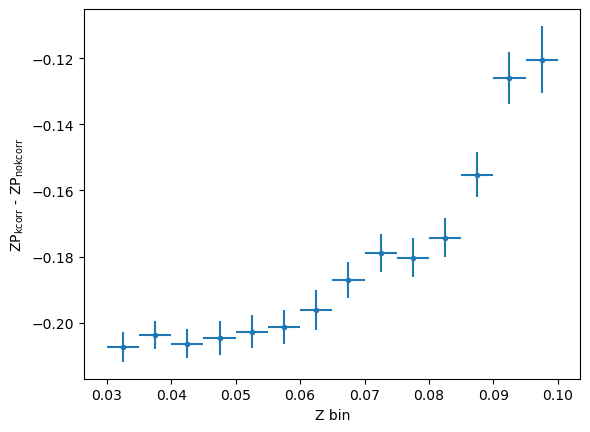

In [192]:
plt.errorbar(x=zc, y=(rk_ZP - r_ZP), 
             xerr = dz,
             yerr= np.sqrt(r_ZP_err**2 + rk_ZP_err**2),
             fmt='.')
plt.xlabel('Z bin')
plt.ylabel(r'ZP$_{\rm kcorr}$ - ZP$_{\rm no kcorr}$')

Text(0, 0.5, '$M_{r \\rm kcorr}$ - $M_{r \\rm no kcorr}$')

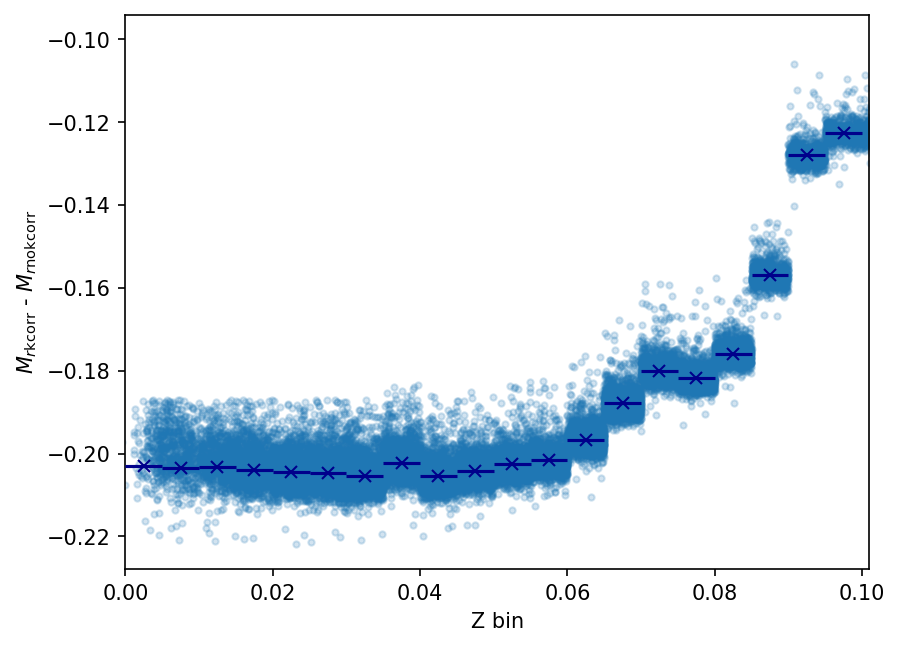

In [194]:
_zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(_zbins)
zc = 0.5*(_zbins[1:] + _zbins[:-1])
sample = ~outlier_boolean
plt.figure(dpi=150)
plt.errorbar(x=SGA_TF['Z_DESI_CMB'], y=(SGA_TF['RK_ABSMAG_SB26_TF'] - SGA_TF['R_ABSMAG_SB26_TF']), 
             # xerr = SGA_TF['ZERR_DESI'],
             # yerr= SGA_TF['R_ABSMAG_SB26_TF_ERR'],
             fmt='.',
             alpha=0.2,
             ecolor='lightgray')
plt.xlim(0,0.101)

N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample], 
                                    (SGA_TF['RK_ABSMAG_SB26_TF'][sample] - SGA_TF['R_ABSMAG_SB26_TF'][sample]), 
                                    _zbins, 
                                    # weights=np.sqrt(SGA_TF['R_MU_TF_ERR'][sample]**2 + SGA_TF['MU_TF_AVG_ERR'][sample]**2)**-2, 
                                    weighted=False)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', zorder=5)

plt.xlabel('Z bin')
plt.ylabel(r'$M_{r \rm kcorr}$ - $M_{r \rm no kcorr}$')


Text(0, 0.5, '$M_{r \\rm kcorr}$ - $M_{r \\rm no kcorr}$')

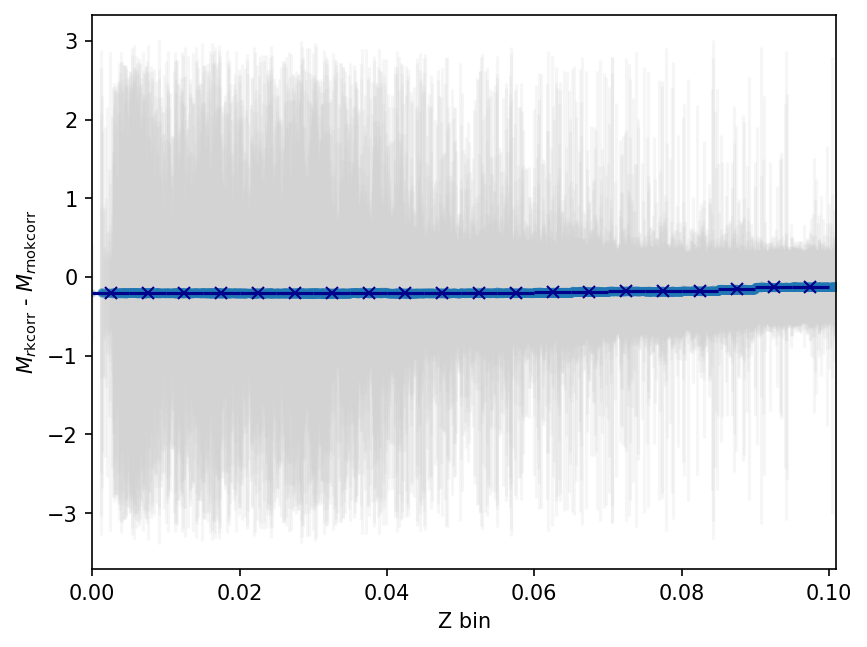

In [195]:
_zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(_zbins)
zc = 0.5*(_zbins[1:] + _zbins[:-1])
sample = ~outlier_boolean
plt.figure(dpi=150)
plt.errorbar(x=SGA_TF['Z_DESI_CMB'], y=(SGA_TF['RK_ABSMAG_SB26_TF'] - SGA_TF['R_ABSMAG_SB26_TF']), 
             # xerr = SGA_TF['ZERR_DESI'],
             yerr= SGA_TF['R_ABSMAG_SB26_TF_ERR'],
             fmt='.',
             alpha=0.2,
             ecolor='lightgray')
plt.xlim(0,0.101)

N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample], 
                                    (SGA_TF['RK_ABSMAG_SB26_TF'][sample] - SGA_TF['R_ABSMAG_SB26_TF'][sample]), 
                                    _zbins, 
                                    # weights=np.sqrt(SGA_TF['R_MU_TF_ERR'][sample]**2 + SGA_TF['MU_TF_AVG_ERR'][sample]**2)**-2, 
                                    weighted=False)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', zorder=5)

plt.xlabel('Z bin')
plt.ylabel(r'$M_{r \rm kcorr}$ - $M_{r \rm no kcorr}$')


Text(0, 0.5, '$\\mu_{\\rm kcorr}$ - $\\mu_{\\rm no kcorr}$')

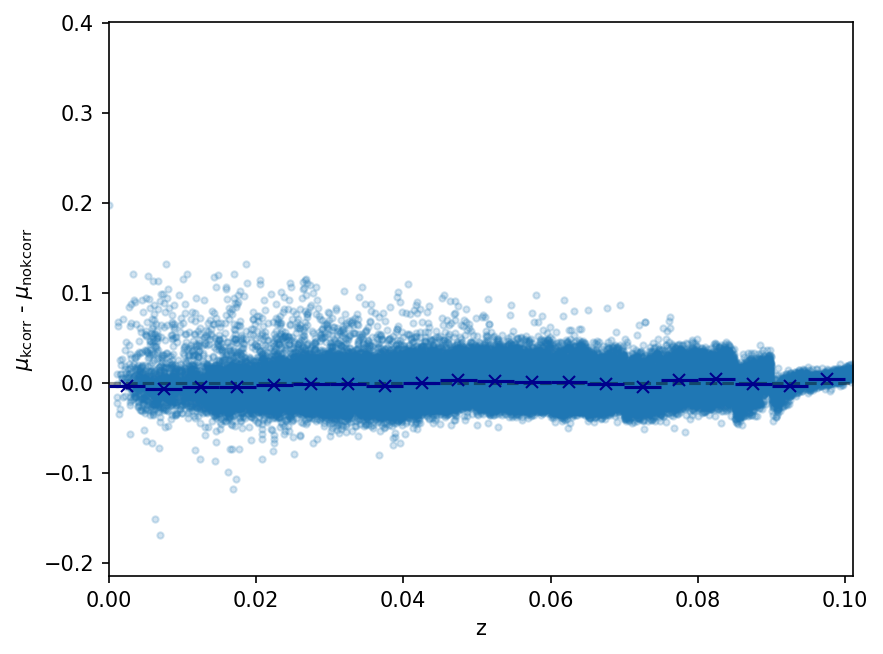

In [204]:
_zbins = np.arange(0, 0.105, 0.005)
dz = 0.5*np.diff(_zbins)
zc = 0.5*(_zbins[1:] + _zbins[:-1])
sample = ~outlier_boolean
plt.figure(dpi=150)
plt.errorbar(x=SGA_TF['Z_DESI_CMB'], y=(SGA_TF['RK_MU_TF'] - SGA_TF['R_MU_TF']), 
             # xerr = SGA_TF['ZERR_DESI'],
             # yerr= np.sqrt(SGA_TF['R_MU_TF_ERR']**2 + SGA_TF['RK_MU_TF_ERR']**2),
             fmt='.',
             alpha=0.2,
             ecolor='lightgray')
plt.xlim(0,0.101)

N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][sample], 
                                    (SGA_TF['RK_MU_TF'][sample] - SGA_TF['R_MU_TF'][sample]), 
                                    _zbins, 
                                    # weights=np.sqrt(SGA_TF['R_MU_TF_ERR'][sample]**2 + SGA_TF['MU_TF_AVG_ERR'][sample]**2)**-2, 
                                    weighted=False)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', zorder=5)
plt.hlines(0, 0, 0.101, linestyles='dashed', colors='k', zorder=4, alpha=0.4)
plt.xlabel('z')
plt.ylabel(r'$\mu_{\rm kcorr}$ - $\mu_{\rm no kcorr}$')
# plt.ylim(-0.15,0.2)


In [129]:
np.mean(SGA_TF['R_ABSMAG_SB26_TF_ERR'])

0.5779861535720038

## Save distance moduli to a file

In [79]:
# Create a single column to denote which objects should be used for cosmological analysis
SGA_TF['MAIN'] = ~SGA_TF['OUTLIER'] & SGA_TF['GOOD_MORPH']

In [83]:
hdr = fits.Header()

hdr['DESI_DR'] = 'DR2'
hdr['V_RADIUS'] = '0.4 R26'
hdr['M'] = r_slope
hdr['M_ERR'] = r_slope_err
# hdr['0PT'] = ZP
# hdr['0PT_ERR'] = ZP_err
hdr['logV0'] = logV0
hdr['SIG'] = np.median(r_tfr_samples[-1])
hdr['SIG_ERR'] = np.sqrt(r_cov_ab[-1,-1])
hdr['H0'] = H0

empty_primary = fits.PrimaryHDU(header=hdr)

In [84]:
table_hdu = fits.BinTableHDU(data=SGA_TF)

hdul = fits.HDUList([empty_primary, table_hdu])

# Write results to file
hdul.writeto('../eta_cats/SGA_jura_jointTFR_v1.fits', 
             overwrite=True)

In [85]:
hdul.writeto('/global/cfs/cdirs/desi/science/td/pv/tfgalaxies/Y3/DESI-DR2_TF_pv_cat_v1.fits', 
             overwrite=True)